In [387]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow. keras import layers, Model
from sklearn.preprocessing import StandardScaler

In [388]:
file_xls = '0_input_parameters_opt_1_1_el_price_dev.xlsx'
meter_ts = pd.read_excel(file_xls, sheet_name='Meter_TS',index_col=0)
solar_ts = pd.read_excel(file_xls, sheet_name='Solar_TS',index_col=0)
tarif_dl = pd.read_excel(file_xls, sheet_name='Tariff_daily',index_col=0)
daytimes =  pd.read_excel(file_xls, sheet_name='DateTime',index_col=0)

In [38]:
#Static Inputs
# Fixed parameters
financial_params = {
    'financial_horizon': 10,  # years
    'discount_rate': 6,      # %
    'pv_fixed_cost': 3000,   # AUD
    'pv_cost_per_kW': 630    # AUD/kW
}

technical_params = {
    'grid_feedin_max': 5,    # kW Maximum grid feed-in until exports are clippedMax grid feed-in until exports are clipped
    'pv_eol_capacity': 80,   # % PV generation capacity remaining at the end of life 
    'pv_eol_years': 25,      # years until PV is considered end-of-life
    'pv_init_soh': 100,      # % Starting state of health of PV system
    'pv_min_capacity': 1,    # kW 
    'pv_max_capacity': 20    # kW
}

  #scenario_names = {
        #            'A_0_te': 'Flat-Flat',
            #        'B_0_te': 'Time-varying-Time-varying',
           #         'C_0_te': 'Time-varying-Flat'

In [389]:
# Step 2: Load target PV sizes
#print("\nLoading target PV sizes...")
excel_output = 'Analysis_techno_econ_el_price_dev_2024_11_12.xlsx'
scenarios = ['A_0_te', 'B_0_te', 'C_0_te', 'A_+5_te','B_+5_te','C_+5_te','A_-5_te', 'B_-5_te','C_-5_te']

In [390]:
class TimeSeriesProcessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.start_date = '2019-04-01'
        self.end_date = '2020-03-31'
        self.hours_per_day = 24
        self.days_per_year = 365
        self.hours_per_week = 168
        self.weeks_per_year = 52
        
    def load_data(self):
        """Load and prepare time series data"""
        print("Loading data...")
        file_xls = '0_input_parameters_opt_1_1_el_price_dev.xlsx'
        
        # Load data
        meter_ts = pd.read_excel(file_xls, sheet_name='Meter_TS', index_col=0)
        solar_ts = pd.read_excel(file_xls, sheet_name='Solar_TS', index_col=0)
        tarif_dl = pd.read_excel(file_xls, sheet_name='Tariff_daily', index_col=0)
        daytimes = pd.read_excel(file_xls, sheet_name='DateTime', index_col=0)

        # Convert 'DateTime1' to datetime format
        daytimes['DateTime1'] = pd.to_datetime(daytimes['DateTime1'])
        datetime_index = pd.DatetimeIndex(daytimes['DateTime1'])

        # Debug print before creating masks
        print("\nDatetime Range Info:")
        print(f"Start date: {datetime_index.min()}")
        print(f"End date: {datetime_index.max()}")
        print(f"Total hours: {len(datetime_index)}")

        # Align indices
        meter_ts.index = datetime_index
        solar_ts.index = datetime_index

        # Process tariffs
        tariffs = self._process_tariffs(tarif_dl, datetime_index)

        # Load PV sizes
        output_file = 'Analysis_techno_econ_el_price_dev_2024_11_12.xlsx'
        pv_sizes = {}
        for scenario in ['A_0_te', 'B_0_te', 'C_0_te']:
            df = pd.read_excel(output_file, sheet_name=scenario)
            pv_sizes[scenario] = df['PV_nomCap_kWp'].values
            print(f"\nScenario {scenario}:")
            print(f"Number of houses: {len(pv_sizes[scenario])}")
            print(f"PV size range: {pv_sizes[scenario].min():.2f} - {pv_sizes[scenario].max():.2f} kWp")
        
        return meter_ts, solar_ts, tariffs, datetime_index, pv_sizes 

    def extract_seasonal_data(self, meter_ts, solar_ts, tariffs, datetime_index):
        """Extract seasonal data based on datetime_index for meters, solar, and tariffs.""" # Corrected docstring
        
        # Define seasons
        season_masks = {
            'autumn': (datetime_index >= "2019-03-01") & (datetime_index < "2019-06-01"),  # March-May 2019
            'winter': (datetime_index >= "2019-06-01") & (datetime_index < "2019-09-01"),  # June-August 2019
            'spring': (datetime_index >= "2019-09-01") & (datetime_index < "2019-12-01"),  # September-November 2019
            'summer': (datetime_index >= "2019-12-01") & (datetime_index < "2020-03-01"),  # December 2019-February 2020
        }
    
        seasonal_data = {}
        
        for season, mask in season_masks.items():
            print(f"\nSeason: {season}")
            print(f"Mask Length: {len(mask)}, Mask True Count: {mask.sum()}")
            print(f"Start: {datetime_index[mask].min()}, End: {datetime_index[mask].max()}")

            # Apply season mask
            seasonal_data[season] = {
                'meter': meter_ts.loc[mask].values,
                'solar': solar_ts.loc[mask].values,
                'tariffs': {
                    scenario: tariffs[scenario][mask]
                    for scenario in tariffs.keys()  # A_0_te, B_0_te, C_0_te
                }
            }
            
            # Debugging: Show data shapes
            print(f"  Meter Shape: {seasonal_data[season]['meter'].shape}")
            print(f"  Solar Shape: {seasonal_data[season]['solar'].shape}")
            for scenario, tariff_data in seasonal_data[season]['tariffs'].items():
                print(f"  {scenario} Tariff Shape: {tariff_data.shape}")
    
        return seasonal_data

    def _process_tariffs(self, tarif_dl, datetime_index):
        """Process tariffs for all schemes""" # Corrected docstring
        tariffs = {}
        
        # Tariff schemes
        schemes = {
            'A': ['0_Im_wkday', '0_Im_wkend', '0_Ex_wkday', '0_Ex_wkend'],
            'B': ['1_Im_wkday', '1_Im_wkend', '1_Ex_wkday', '1_Ex_wkend'],
            'C': ['2_Im_wkday', '2_Im_wkend', '2_Ex_wkday', '2_Ex_wkend']
        }
        
        for scheme, cols in schemes.items():
            # Extract tariff data
            scheme_data = {
                'import_wkday': tarif_dl[cols[0]],
                'import_wkend': tarif_dl[cols[1]],
                'export_wkday': tarif_dl[cols[2]],
                'export_wkend': tarif_dl[cols[3]]
            }
            
            # Expand to hourly values
            hourly_tariffs = self._expand_tariffs(scheme_data, datetime_index)
            tariffs[f'{scheme}_0_te'] = hourly_tariffs
        
        return tariffs
        
    def _expand_tariffs(self, scheme_data, datetime_index):
        """Expand daily tariffs to hourly values considering weekday/weekend"""
        n_hours = len(datetime_index)
        import_tariffs = np.zeros(n_hours)
        export_tariffs = np.zeros(n_hours)
        
        for hour in range(n_hours):
            hour_of_day = datetime_index[hour].hour
            is_weekend = datetime_index[hour].weekday() >= 5
            
            # Set appropriate rate based on weekday/weekend
            if is_weekend:
                import_tariffs[hour] = scheme_data['import_wkend'].iloc[hour_of_day]
                export_tariffs[hour] = scheme_data['export_wkend'].iloc[hour_of_day]
            else:
                import_tariffs[hour] = scheme_data['import_wkday'].iloc[hour_of_day]
                export_tariffs[hour] = scheme_data['export_wkday'].iloc[hour_of_day]

        # Round to three decimal places
        import_tariffs = np.round(import_tariffs, 3)
        export_tariffs = np.round(export_tariffs, 3)
        
        return np.column_stack((import_tariffs, export_tariffs))


In [391]:
processor = TimeSeriesProcessor()  # Create an instance of the class
meter_ts, solar_ts, tariffs, datetime_index, pv_sizes = processor.load_data()  # Call load_data to load the data

# Now you can print the indices:
print("Meter_TS index sample:")
print(meter_ts.index)

print("Solar_TS index sample:")
print(solar_ts.index)

print("Tariff index sample:")
print(pd.DataFrame(tariffs["A_0_te"]).index)


Loading data...

Datetime Range Info:
Start date: 2019-04-01 00:00:00
End date: 2020-03-31 23:00:00
Total hours: 8760

Scenario A_0_te:
Number of houses: 400
PV size range: 1.00 - 9.12 kWp

Scenario B_0_te:
Number of houses: 400
PV size range: 1.00 - 9.28 kWp

Scenario C_0_te:
Number of houses: 400
PV size range: 1.00 - 9.27 kWp
Meter_TS index sample:
DatetimeIndex(['2019-04-01 00:00:00', '2019-04-01 01:00:00',
               '2019-04-01 02:00:00', '2019-04-01 03:00:00',
               '2019-04-01 04:00:00', '2019-04-01 05:00:00',
               '2019-04-01 06:00:00', '2019-04-01 07:00:00',
               '2019-04-01 08:00:00', '2019-04-01 09:00:00',
               ...
               '2020-03-31 14:00:00', '2020-03-31 15:00:00',
               '2020-03-31 16:00:00', '2020-03-31 17:00:00',
               '2020-03-31 18:00:00', '2020-03-31 19:00:00',
               '2020-03-31 20:00:00', '2020-03-31 21:00:00',
               '2020-03-31 22:00:00', '2020-03-31 23:00:00'],
              dt

In [42]:
print(pd.DataFrame(tariffs["A_0_te"]).index) 
print("Meter_TS index sample:")

RangeIndex(start=0, stop=8760, step=1)
Meter_TS index sample:


In [43]:
processed_tariffs = {}

for scenario, tariff_data in tariffs.items():
    if len(tariff_data) == len(datetime_index):
        processed_tariffs[scenario] = pd.DataFrame(
            tariff_data, columns=["Import_Tariff", "Export_Tariff"], index=datetime_index
        )
    else:
        raise ValueError(
            f"Length mismatch for {scenario}: Tariff data has {len(tariff_data)} rows, "
            f"but datetime_index has {len(datetime_index)} elements."
        )


In [44]:
for scenario, df in processed_tariffs.items():
    print(f"\nScenario: {scenario}")
    print(df.head())  # First few rows
    print(df.index)   # Confirm index alignment



Scenario: A_0_te
                     Import_Tariff  Export_Tariff
DateTime1                                        
2019-04-01 00:00:00          0.243          0.052
2019-04-01 01:00:00          0.243          0.052
2019-04-01 02:00:00          0.243          0.052
2019-04-01 03:00:00          0.243          0.052
2019-04-01 04:00:00          0.243          0.052
DatetimeIndex(['2019-04-01 00:00:00', '2019-04-01 01:00:00',
               '2019-04-01 02:00:00', '2019-04-01 03:00:00',
               '2019-04-01 04:00:00', '2019-04-01 05:00:00',
               '2019-04-01 06:00:00', '2019-04-01 07:00:00',
               '2019-04-01 08:00:00', '2019-04-01 09:00:00',
               ...
               '2020-03-31 14:00:00', '2020-03-31 15:00:00',
               '2020-03-31 16:00:00', '2020-03-31 17:00:00',
               '2020-03-31 18:00:00', '2020-03-31 19:00:00',
               '2020-03-31 20:00:00', '2020-03-31 21:00:00',
               '2020-03-31 22:00:00', '2020-03-31 23:00:00'],
  

In [45]:
import pandas as pd
import os

def save_scenario_tariffs(processed_tariffs, output_dir='tariff_data'):
    """
    Save tariff data for each scenario to separate CSV files.
    
    Args:
        processed_tariffs (dict): Dictionary of DataFrames containing tariff data for each scenario
        output_dir (str): Directory where files will be saved
    
    Returns:
        dict: Dictionary with scenarios as keys and saved file paths as values
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    saved_files = {}
    
    for scenario, tariff_df in processed_tariffs.items():
        # Create a clean filename
        clean_scenario = scenario.replace('/', '_').replace('\\', '_')
        filename = f'tariffs_{clean_scenario}.csv'
        filepath = os.path.join(output_dir, filename)
        
        try:
            # Save the DataFrame
            tariff_df.to_csv(filepath)
            saved_files[scenario] = filepath
            print(f"Successfully saved {scenario} tariffs to: {filepath}")
            
            # Verify file was saved correctly
            file_size = os.path.getsize(filepath)
            row_count = len(pd.read_csv(filepath))
            print(f"Verified file: {row_count} rows, {file_size/1024:.2f} KB")
            
        except Exception as e:
            print(f"Error saving {scenario} tariffs: {str(e)}")
            
    return saved_files

# Function to verify saved data
def verify_saved_tariffs(saved_files, original_data):
    """
    Verify that saved tariff files match the original data.
    
    Args:
        saved_files (dict): Dictionary of saved file paths
        original_data (dict): Original processed tariffs dictionary
    """
    print("\nVerifying saved files:")
    print("-" * 50)
    
    for scenario, filepath in saved_files.items():
        # Read saved file
        saved_df = pd.read_csv(filepath)
        original_df = original_data[scenario]
        
        # Compare dimensions
        print(f"\nScenario: {scenario}")
        print(f"Original rows: {len(original_df)}, Saved rows: {len(saved_df)}")
        
        # Compare sample values
        if len(saved_df) == len(original_df):
            print("✓ Row counts match")
        else:
            print("⚠ Row counts differ!")

In [16]:
# Save all scenario tariffs
saved_files = save_scenario_tariffs(processed_tariffs)

# Verify the saved files
verify_saved_tariffs(saved_files, processed_tariffs)

Successfully saved A_0_te tariffs to: tariff_data/tariffs_A_0_te.csv
Verified file: 8760 rows, 273.79 KB
Successfully saved B_0_te tariffs to: tariff_data/tariffs_B_0_te.csv
Verified file: 8760 rows, 269.98 KB
Successfully saved C_0_te tariffs to: tariff_data/tariffs_C_0_te.csv
Verified file: 8760 rows, 273.79 KB

Verifying saved files:
--------------------------------------------------

Scenario: A_0_te
Original rows: 8760, Saved rows: 8760
✓ Row counts match

Scenario: B_0_te
Original rows: 8760, Saved rows: 8760
✓ Row counts match

Scenario: C_0_te
Original rows: 8760, Saved rows: 8760
✓ Row counts match


In [17]:
# Check meter data
print("\n=== First values of Meter Time Series ===")
if meter_ts is not None and not meter_ts.empty:
    print(meter_ts.head())
else:
    print("Meter data is empty")

# Check solar data
print("\n=== First values of Solar Time Series ===")
if solar_ts is not None and not solar_ts.empty:
    print(solar_ts.head())
else:
    print("Solar data is empty")

# Check processed tariff data
print("\n=== First values of Processed Tariffs ===")
if processed_tariffs:
    for scenario, tariff_array in processed_tariffs.items():
        print(f"\nScenario: {scenario}")
        df_tariff = pd.DataFrame(
            tariff_array,
            index=datetime_index,
            columns=['Import_Tariff', 'Export_Tariff']
        )
        print(df_tariff.head())
else:
    print("Processed tariff data is empty")


=== First values of Meter Time Series ===
                     pc3032_nmi1556854887  pc3016_nmi1544956794  \
DateTime1                                                         
2019-04-01 00:00:00                0.6687                0.1000   
2019-04-01 01:00:00                0.2312                0.0875   
2019-04-01 02:00:00                0.2499                0.0812   
2019-04-01 03:00:00                0.1187                0.0874   
2019-04-01 04:00:00                0.1437                0.0875   

                     pc3039_nmi4677620677  pc3032_nmi8006940484  \
DateTime1                                                         
2019-04-01 00:00:00                0.3812                0.1000   
2019-04-01 01:00:00                0.3750                0.1124   
2019-04-01 02:00:00                0.3750                0.0999   
2019-04-01 03:00:00                0.3937                0.0937   
2019-04-01 04:00:00                0.4499                0.1062   

                 

In [46]:
def combine_scenario_data(meter_ts, solar_ts, processed_tariffs, scenario, pv_cost):
    """
    Combine meter, solar, and tariff data into a single DataFrame for one scenario.
    
    Args:
        meter_ts (pd.DataFrame): Meter time series data (8760 x 400).
        solar_ts (pd.DataFrame): Solar generation time series data (8760 x 1).
        processed_tariffs (pd.DataFrame): Tariff data (8760 x 2) with columns ['Import_Tariff', 'Export_Tariff'].
        scenario (str): Scenario name (e.g., "A_0_te").
        pv_cost (float): Fixed PV cost value.
    
    Returns:
        pd.DataFrame: Combined DataFrame for the scenario.
    """
    # Start with meter data
    combined_df = meter_ts.copy()

    # Add solar data
    combined_df["MELB"] = solar_ts["MELB"]

    # Add import and export tariffs from the DataFrame
    combined_df["Import_Tariff"] = processed_tariffs["Import_Tariff"]
    combined_df["Export_Tariff"] = processed_tariffs["Export_Tariff"]

    # Add PV cost (constant value for all rows)
    combined_df["PV_Cost"] = pv_cost

    return combined_df


In [47]:
combined_scenarios = {}

for scenario in ["A_0_te", "B_0_te", "C_0_te"]:
    print(f"\nProcessing scenario: {scenario}")
    tariff_data = processed_tariffs[scenario]
    print(f"Tariff data columns: {tariff_data.columns}")
    print(tariff_data.head())  # Show the first 5 rows of tariff data for debugging
    
    combined_scenarios[scenario] = combine_scenario_data(
        meter_ts, 
        solar_ts, 
        tariff_data,  # Pass the DataFrame directly
        scenario, 
        pv_cost=3000
    )



Processing scenario: A_0_te
Tariff data columns: Index(['Import_Tariff', 'Export_Tariff'], dtype='object')
                     Import_Tariff  Export_Tariff
DateTime1                                        
2019-04-01 00:00:00          0.243          0.052
2019-04-01 01:00:00          0.243          0.052
2019-04-01 02:00:00          0.243          0.052
2019-04-01 03:00:00          0.243          0.052
2019-04-01 04:00:00          0.243          0.052

Processing scenario: B_0_te
Tariff data columns: Index(['Import_Tariff', 'Export_Tariff'], dtype='object')
                     Import_Tariff  Export_Tariff
DateTime1                                        
2019-04-01 00:00:00          0.184          0.071
2019-04-01 01:00:00          0.184          0.071
2019-04-01 02:00:00          0.184          0.071
2019-04-01 03:00:00          0.184          0.071
2019-04-01 04:00:00          0.184          0.071

Processing scenario: C_0_te
Tariff data columns: Index(['Import_Tariff', 'Export_Ta

In [48]:
for scenario, df in combined_scenarios.items():
    print(f"\nFirst 5 rows for {scenario}:")
    print(df.head())  # Display the first 5 rows of the combined DataFrame
    print(f"Shape of combined data for {scenario}: {df.shape}")



First 5 rows for A_0_te:
                     pc3032_nmi1556854887  pc3016_nmi1544956794  \
DateTime1                                                         
2019-04-01 00:00:00                0.6687                0.1000   
2019-04-01 01:00:00                0.2312                0.0875   
2019-04-01 02:00:00                0.2499                0.0812   
2019-04-01 03:00:00                0.1187                0.0874   
2019-04-01 04:00:00                0.1437                0.0875   

                     pc3039_nmi4677620677  pc3032_nmi8006940484  \
DateTime1                                                         
2019-04-01 00:00:00                0.3812                0.1000   
2019-04-01 01:00:00                0.3750                0.1124   
2019-04-01 02:00:00                0.3750                0.0999   
2019-04-01 03:00:00                0.3937                0.0937   
2019-04-01 04:00:00                0.4499                0.1062   

                     pc3072_nmi594

In [49]:
# Check for February 29th in the index
leap_day = "2020-02-29"
for scenario, df in combined_scenarios.items():
    print(f"\nScenario: {scenario}")
    if pd.Timestamp(leap_day) in df.index:
        print(f"{leap_day} is present in the data.")
    else:
        print(f"{leap_day} is missing from the data.")




Scenario: A_0_te
2020-02-29 is missing from the data.

Scenario: B_0_te
2020-02-29 is missing from the data.

Scenario: C_0_te
2020-02-29 is missing from the data.


In [50]:
def apply_sequential_averaging_correctly_centered(df, interval):
    """
    Apply sequential averaging per day for a given interval with correctly centered DateTime index.

    Args:
        df (pd.DataFrame): Input DataFrame with a DateTime index.
        interval (int): Time interval in hours for averaging.

    Returns:
        pd.DataFrame: DataFrame with sequentially averaged features and centered DateTime index.
    """
    daily_results = []  # Store results for each day
    grouped = df.groupby(df.index.date)  # Group data by day

    for day, group in grouped:
        if len(group) == 24:  # Ensure the group has 24 hours
            # Resample within the day and compute the mean
            averaged = group.resample(f'{interval}H', label='left', closed='left').mean()

            # Ensure the correct number of rows for the day
            expected_rows = 24 // interval
            averaged = averaged.iloc[:expected_rows]

            # Adjust index to represent the center of each interval
            averaged.index = averaged.index + pd.Timedelta(hours=interval // 2)

            daily_results.append(averaged)

    # Concatenate results for all days
    return pd.concat(daily_results)


In [51]:
intervals = [2, 3, 4, 6]
corrected_sequential_results = {}

for scenario, df in combined_scenarios.items():
    print(f"\nProcessing Scenario: {scenario}")
    scenario_results = {}
    for interval in intervals:
        print(f"  Applying {interval}-hour sequential averaging per day.")
        scenario_results[f"{interval}_hour"] = apply_sequential_averaging_correctly_centered(df, interval)
    corrected_sequential_results[scenario] = scenario_results



Processing Scenario: A_0_te
  Applying 2-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 3-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 4-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 6-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()



Processing Scenario: B_0_te
  Applying 2-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 3-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 4-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 6-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()



Processing Scenario: C_0_te
  Applying 2-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 3-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 4-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


  Applying 6-hour sequential averaging per day.


/tmp/ipykernel_314776/2312785157.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  averaged = group.resample(f'{interval}H', label='left', closed='left').mean()


In [52]:
for scenario, intervals in corrected_sequential_results.items():
    print(f"\nScenario: {scenario}")
    for interval, result_df in intervals.items():
        print(f"  Interval: {interval}, Shape: {result_df.shape}")
        print(result_df.head(10))  # Check first 10 rows



Scenario: A_0_te
  Interval: 2_hour, Shape: (4380, 404)
                     pc3032_nmi1556854887  pc3016_nmi1544956794  \
DateTime1                                                         
2019-04-01 01:00:00               0.44995               0.09375   
2019-04-01 03:00:00               0.18430               0.08430   
2019-04-01 05:00:00               0.13435               0.08125   
2019-04-01 07:00:00               0.13125               0.55000   
2019-04-01 09:00:00               0.13120               0.54680   
2019-04-01 11:00:00               0.85620               0.44680   
2019-04-01 13:00:00               1.23430               0.32810   
2019-04-01 15:00:00               0.98745               0.47805   
2019-04-01 17:00:00               0.69055               0.50310   
2019-04-01 19:00:00               1.13430               0.39680   

                     pc3039_nmi4677620677  pc3032_nmi8006940484  \
DateTime1                                                         
2019

In [53]:
import os

output_dir = "corrected_sequential_results"
os.makedirs(output_dir, exist_ok=True)

for scenario, intervals in corrected_sequential_results.items():
    for interval, result_df in intervals.items():
        filename = os.path.join(output_dir, f"{scenario}_{interval}_hour.csv")
        result_df.to_csv(filename)
        print(f"Saved: {filename}")


Saved: corrected_sequential_results/A_0_te_2_hour_hour.csv
Saved: corrected_sequential_results/A_0_te_3_hour_hour.csv
Saved: corrected_sequential_results/A_0_te_4_hour_hour.csv
Saved: corrected_sequential_results/A_0_te_6_hour_hour.csv
Saved: corrected_sequential_results/B_0_te_2_hour_hour.csv
Saved: corrected_sequential_results/B_0_te_3_hour_hour.csv
Saved: corrected_sequential_results/B_0_te_4_hour_hour.csv
Saved: corrected_sequential_results/B_0_te_6_hour_hour.csv
Saved: corrected_sequential_results/C_0_te_2_hour_hour.csv
Saved: corrected_sequential_results/C_0_te_3_hour_hour.csv
Saved: corrected_sequential_results/C_0_te_4_hour_hour.csv
Saved: corrected_sequential_results/C_0_te_6_hour_hour.csv


In [392]:
final_combined_matrices = {}

for scenario, intervals in corrected_sequential_results.items():
    print(f"\nProcessing Scenario: {scenario}")
    
    # Get PV size directly for this scenario
    pv_size = pv_sizes[scenario].reshape(-1, 1)  # Shape: (400, 1)

    scenario_results = {}

    for interval, df in intervals.items():
        print(f"  Interval: {interval}, Shape: {df.shape}")

        # 1. Extract Meter Data (House-specific, each column for a house)
        meter_data = df.iloc[:, :400].values.T  # Transpose to (400, 4380)

        # 2. Extract Solar Data (same for all houses)
        solar_data = df['MELB'].values.reshape(1, -1)  # Shape: (1, 4380)
        solar_features = np.tile(solar_data, (400, 1))  # (400, 4380)

        # 3. Extract Import Tariff (same for all houses)
        import_tariff = df['Import_Tariff'].values.reshape(1, -1)  # Shape: (1, 4380)
        import_tariff_features = np.tile(import_tariff, (400, 1))  # (400, 4380)

        # 4. Extract Export Tariff (same for all houses)
        export_tariff = df['Export_Tariff'].values.reshape(1, -1)  # Shape: (1, 4380)
        export_tariff_features = np.tile(export_tariff, (400, 1))  # (400, 4380)

        # 5. Combine All Features and PV Size
        combined_matrix = np.hstack([
            meter_data,              # (400, 4380)
            solar_features,          # (400, 4380)
            import_tariff_features,  # (400, 4380)
            export_tariff_features,  # (400, 4380)
            pv_size                  # (400, 1)
        ])

        print(f"    Combined shape: {combined_matrix.shape}")

        # Save Combined Matrix for This Interval
        scenario_results[interval] = combined_matrix

        # Optionally Save to CSV
        output_file = os.path.join(output_dir, f"{scenario}_{interval}_combined_features.csv")
        pd.DataFrame(combined_matrix).to_csv(output_file, index=False, header=False)
        print(f"    Saved to {output_file}")

    # Store Results
    final_combined_matrices[scenario] = scenario_results

print("\nAll matrices processed and saved.")



Processing Scenario: A_0_te
  Interval: 2_hour, Shape: (4380, 404)
    Combined shape: (400, 17521)
    Saved to predictions_vs_actuals_plots/A_0_te_2_hour_combined_features.csv
  Interval: 3_hour, Shape: (2920, 404)
    Combined shape: (400, 11681)
    Saved to predictions_vs_actuals_plots/A_0_te_3_hour_combined_features.csv
  Interval: 4_hour, Shape: (2190, 404)
    Combined shape: (400, 8761)
    Saved to predictions_vs_actuals_plots/A_0_te_4_hour_combined_features.csv
  Interval: 6_hour, Shape: (1460, 404)
    Combined shape: (400, 5841)
    Saved to predictions_vs_actuals_plots/A_0_te_6_hour_combined_features.csv

Processing Scenario: B_0_te
  Interval: 2_hour, Shape: (4380, 404)
    Combined shape: (400, 17521)
    Saved to predictions_vs_actuals_plots/B_0_te_2_hour_combined_features.csv
  Interval: 3_hour, Shape: (2920, 404)
    Combined shape: (400, 11681)
    Saved to predictions_vs_actuals_plots/B_0_te_3_hour_combined_features.csv
  Interval: 4_hour, Shape: (2190, 404)
    C

In [393]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import matplotlib.pyplot as plt

# Define the neural network architecture
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu',
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(16, activation='relu',
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

scenarios = ["A_0_te", "B_0_te", "C_0_te"]
windows = ["2_hour", "3_hour", "4_hour", "6_hour"]
base_path = "corrected_sequential_results"
data_dict = {}  # Dictionary to store data for each scenario and window

for scenario in scenarios:
    for window in windows:
        file_name = f"{scenario}_{window}_combined_features.csv"
        file_path = os.path.join(base_path, file_name)
        
        if os.path.exists(file_path):
            print(f"Loading file: {file_path}")
            data = pd.read_csv(file_path)
            
            # Separate features and target
            X = data.iloc[:, :-1].values  # Features
            y = data.iloc[:, -1].values  # Target
            
            data_dict[(scenario, window)] = (X, y)
        else:
            print(f"File {file_name} not found.")


Loading file: corrected_sequential_results/A_0_te_2_hour_combined_features.csv
Loading file: corrected_sequential_results/A_0_te_3_hour_combined_features.csv
Loading file: corrected_sequential_results/A_0_te_4_hour_combined_features.csv
Loading file: corrected_sequential_results/A_0_te_6_hour_combined_features.csv
Loading file: corrected_sequential_results/B_0_te_2_hour_combined_features.csv
Loading file: corrected_sequential_results/B_0_te_3_hour_combined_features.csv
Loading file: corrected_sequential_results/B_0_te_4_hour_combined_features.csv
Loading file: corrected_sequential_results/B_0_te_6_hour_combined_features.csv
Loading file: corrected_sequential_results/C_0_te_2_hour_combined_features.csv
Loading file: corrected_sequential_results/C_0_te_3_hour_combined_features.csv
Loading file: corrected_sequential_results/C_0_te_4_hour_combined_features.csv
Loading file: corrected_sequential_results/C_0_te_6_hour_combined_features.csv


In [394]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import joblib

# Create a directory to save normalized data
os.makedirs("standardized_data", exist_ok=True)

def standardized_data(X, y):
    """
    Normalize feature matrix X and target vector y.

    Args:
        X (pd.DataFrame or np.ndarray): Feature matrix.
        y (pd.Series or np.ndarray): Target vector.

    Returns:
        tuple: Normalized feature matrix, normalized target vector, scalers for X and y.
    """

    print("Before standardization:")
    print("Y values (first 5):", y[:5])
    print("Y mean:", np.mean(y))
    print("Y std:", np.std(y))
    # Normalize features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    # Normalize target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    # Print verification
    print("Original y first 5:", y[:5])
    print("Scaled y first 5:", y_scaled[:5])
    print("Scaler mean:", scaler_y.mean_)
    print("Scaler scale:", scaler_y.scale_)

    # Test denormalization immediately
    y_test = scaler_y.inverse_transform(y_scaled.reshape(-1,1))
    print("\nTest denormalization:")
    print("Denormalized Y (first 5):", y_test[:5].flatten())
    
    # Save scaler_y for later use
    
    scaler_path = f'scalers/scaler_y_{scenario}_{window}.save'
    joblib.dump(scaler_y, scaler_path)
    print(f"Saved scaler to: {scaler_path}")
    
    return X_scaled, y_scaled, scaler_X, scaler_y

# Normalize and save data
for scenario, windows_data in final_combined_matrices.items():
    for window, data in windows_data.items():
        print(f"\nProcessing Scenario: {scenario}, Window: {window}")
        
        # Extract features (X) and target (y)
        X = data[:, :-1]  # All columns except the last one
        y = data[:, -1]   # The last column as target
        
        # Normalize data
        X_scaled, y_scaled, scaler_X, scaler_y = standardized_data(X, y)
        
        # Save normalized data to files
        #X_filename = f"normalized_data/{scenario}_{window}_features.csv"
        #y_filename = f"normalized_data/{scenario}_{window}_target.csv"
        X_filename = f"standardized_data/{scenario}_{window}_features.csv"  # Updated path
        y_filename = f"standardized_data/{scenario}_{window}_target.csv"  # Updated path
        
        pd.DataFrame(X_scaled).to_csv(X_filename, index=False)
        pd.DataFrame(y_scaled, columns=["Target"]).to_csv(y_filename, index=False)
        
        
        print(f"Saved Standardized features to {X_filename}")
        print(f"Saved standardized target to {y_filename}")



Processing Scenario: A_0_te, Window: 2_hour
Before standardization:
Y values (first 5): [5.46216134 2.97293582 2.82029114 2.13782333 2.70791292]
Y mean: 4.553132082387253
Y std: 2.0675015845819575
Original y first 5: [5.46216134 2.97293582 2.82029114 2.13782333 2.70791292]
Scaled y first 5: [ 0.43967524 -0.76430232 -0.83813282 -1.16822583 -0.89248742]
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]

Test denormalization:
Denormalized Y (first 5): [5.46216134 2.97293582 2.82029114 2.13782333 2.70791292]
Saved scaler to: scalers/scaler_y_A_0_te_2_hour.save
Saved Standardized features to standardized_data/A_0_te_2_hour_features.csv
Saved standardized target to standardized_data/A_0_te_2_hour_target.csv

Processing Scenario: A_0_te, Window: 3_hour
Before standardization:
Y values (first 5): [5.46216134 2.97293582 2.82029114 2.13782333 2.70791292]
Y mean: 4.553132082387253
Y std: 2.0675015845819575
Original y first 5: [5.46216134 2.97293582 2.82029114 2.13782333 2.70791292]
Scaled y f

In [395]:
def plot_predictions_vs_actual(y_true, y_pred, scenario, window, save_path):
    plt.figure(figsize=(10, 10))  # Make figure square with equal dimensions
    
    # Scenario name mapping
    scenario_names = {
        'A_0_te': 'Flat-Flat',
        'B_0_te': 'Time-varying-Time-varying',
        'C_0_te': 'Time-varying-Flat'
    }
    
    # Get proper scenario name
    scenario_name = scenario_names.get(scenario, scenario)
    
    # Determine max value from the actual data
    data_max = max(max(y_true), max(y_pred))
    # Round up to nearest integer to make a clean plot limit
    max_pv = np.ceil(data_max)
    
    # Create proper 45-degree line
    line_min = 0
    line_max = max_pv
    plt.plot([line_min, line_max], [line_min, line_max], 
             'r-', label='Perfect Prediction', alpha=0.7)
    
    # Plot scatter points
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
    
    plt.xlabel('Actual PV Size (kWp)')
    plt.ylabel('Predicted PV Size (kWp)')
    plt.title(f'Predicted vs Actual PV Size\nScenario: {scenario_name}, Window: {window}')
    plt.legend()
    
    # Set identical limits for both axes
    plt.xlim(0, max_pv)
    plt.ylim(0, max_pv)
    
    # Ensure square plot with equal scales
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.grid(True, alpha=0.3)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save plot
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close()

In [396]:
def align_histories(histories):
    # Find the shortest history length across all folds
    min_length = min(len(h['loss']) for h in histories)

    # Truncate each history to the shortest length
    aligned_histories = [{'loss': h['loss'][:min_length], 'val_loss': h['val_loss'][:min_length]} for h in histories]
    return aligned_histories

In [397]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, gc, psutil, joblib
import tensorflow as tf

# Configure TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.keras.backend.clear_session()

def build_custom_nn(input_dim, num_hidden_layers=1, neurons_per_layer=32,
                   activation='relu', dropout_rate=0.4, learning_rate=0.001,
                   l1_reg=0.01, l2_reg=0.01):
    """Build neural network with customizable architecture."""
    model = Sequential()
    
    # Input layer with regularization
    model.add(Dense(neurons_per_layer,
                   activation=activation,
                   input_shape=(input_dim,),
                   kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(neurons_per_layer,
                       activation=activation,
                       kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def save_and_load_model(model, scenario, window, fold, base_dir='models'):
    """Safely save and verify model."""
    os.makedirs(base_dir, exist_ok=True)
    window_name = window.replace('_', '-')
    model_path = os.path.join(base_dir, f'{scenario}_{window_name}_fold_{fold + 1}.h5')
    
    try:
        model.save(model_path, save_format='h5')
        print(f"Successfully saved model to {model_path}")
        loaded_model = load_model(model_path)
        print("Successfully verified model loading")
        return model_path
    except Exception as e:
        print(f"Error saving/loading model: {e}")
        try:
            print("Trying alternate saving method...")
            model.save_weights(model_path)
            print(f"Successfully saved model weights to {model_path}")
            return model_path
        except Exception as e2:
            print(f"Error saving weights: {e2}")
            return None

def plot_predictions_vs_actual(y_true, y_pred, scenario, window, save_path):
    """Create prediction vs actual plot."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    plt.title(f'Predictions vs Actual - {scenario} {window}\nMAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}')
    plt.xlabel('Actual PV Size (kWp)')
    plt.ylabel('Predicted PV Size (kWp)')
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

# Parameter grid
param_grid = {
    'num_hidden_layers': [2, 3],
    'neurons_per_layer': [32, 64, 128],
    'batch_size': [32, 64],
    'epochs': [100],
    'learning_rate': [0.001],
    'dropout_rate': [0.4],
    'activation': ['relu'],
    'l1_reg': [0.005],
    'l2_reg': [0.005]
}

# Create directories
os.makedirs("grid_search_results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("predictions", exist_ok=True)

# Set up cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = {}

# Main training loop
for scenario, windows_data in final_combined_matrices.items():
    results[scenario] = {}
    
    for window, data in windows_data.items():
        print(f"\nProcessing Scenario: {scenario}, Window: {window}")
        
        # Load standardized data
        X_path = f"standardized_data/{scenario}_{window}_features.csv"
        y_path = f"standardized_data/{scenario}_{window}_target.csv"
        X = pd.read_csv(X_path).values
        y = pd.read_csv(y_path).values.flatten()
        
        # Store results
        param_results = []
        all_fold_predictions = []
        all_fold_actuals = []
        all_fold_histories = []
        
        # Generate parameter combinations
        from itertools import product
        param_combinations = [dict(zip(param_grid.keys(), v)) 
                            for v in product(*param_grid.values())]
        
        for params in param_combinations:
            fold_metrics = []
            histories = []
            
            # Cross-validation
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"  Training fold {fold + 1}/3 for parameters: {params}")
                
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Try to load existing model
                model_path = os.path.join('models', f'{scenario}_{window}_fold_{fold + 1}.h5')
                
                if os.path.exists(model_path):
                    try:
                        print(f"Loading existing model from {model_path}")
                        model = load_model(model_path)
                    except Exception as e:
                        print(f"Error loading model: {e}")
                        print("Training new model...")
                        model = None
                else:
                    model = None
                
                if model is None:
                    # Build and train new model
                    model = build_custom_nn(
                        input_dim=X.shape[1],
                        num_hidden_layers=params['num_hidden_layers'],
                        neurons_per_layer=params['neurons_per_layer'],
                        activation=params['activation'],
                        dropout_rate=params['dropout_rate'],
                        learning_rate=params['learning_rate'],
                        l1_reg=params['l1_reg'],
                        l2_reg=params['l2_reg']
                    )
                    
                    early_stopping = EarlyStopping(
                        monitor='val_loss',
                        patience=7,
                        restore_best_weights=True
                    )
                    
                    history = model.fit(
                        X_train, y_train,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0
                    )
                    
                    # Save the model
                    saved_path = save_and_load_model(model, scenario, window, fold)
                    if not saved_path:
                        print("Warning: Could not save model, but continuing...")
                
                # Load the correct scaler for this scenario/window
                scaler_y = joblib.load(f'scalers/scaler_y_{scenario}_{window}.save')
                print("Loaded scaler parameters:")
                print("Scaler mean:", scaler_y.mean_)
                print("Scaler scale:", scaler_y.scale_)
                
                predictions = model.predict(X_val)
                # Reshape predictions to match scaler expectation
                predictions_reshaped = predictions.reshape(-1, 1)
                y_val_reshaped = y_val.reshape(-1, 1)

                # Test with known values
                test_scaled = np.array([[0.0]])  # Should denormalize to mean value
                print("Test denorm of 0:", scaler_y.inverse_transform(test_scaled)[0][0])  # Should be ~7.48

                predictions_denorm = scaler_y.inverse_transform(predictions_reshaped)
                y_val_denorm = scaler_y.inverse_transform(y_val_reshaped)

                # Verification prints
                # Print verification
                print("\nSample of original/denormalized values:")
                print("Original y (first 5):", y_val_reshaped[:5].flatten())
                print("Denormalized y (first 5):", y_val_denorm[:5].flatten())
                print("Original shape predictions:", predictions.shape)
                print("Reshaped predictions shape:", predictions_reshaped.shape)
                print("Denormalized predictions shape:", predictions_denorm.shape)
                print("Scaled predictions first 5:", predictions[:5].flatten())
                print("Denormalized predictions first 5:", predictions_denorm[:5].flatten())
                print("Original y_val first 5:", y_val[:5])
                print("Denormalized y_val first 5:", y_val_denorm[:5].flatten())
                
                # Save predictions
                scenario_window_dir = f"predictions/{scenario}_{window}"
                os.makedirs(scenario_window_dir, exist_ok=True)
                
                fold_predictions_df = pd.DataFrame({
                    "House_Index": val_idx,
                    "Actual": y_val_denorm.flatten(),
                    "Predicted": predictions_denorm.flatten(),
                    "Scenario": scenario,
                    "Window": window,
                    "Fold": fold + 1,
                    "Original_Index": np.arange(len(y_val_denorm))
                })
                
                fold_predictions_file = f"{scenario_window_dir}/fold_{fold + 1}_predictions.csv"
                fold_predictions_df.to_csv(fold_predictions_file, index=False)
                
                # Calculate metrics
                metrics = {
                    'mae': mean_absolute_error(y_val_denorm, predictions_denorm),
                    'mse': mean_squared_error(y_val_denorm, predictions_denorm),
                    'r2': r2_score(y_val_denorm, predictions_denorm)
                }
                
                fold_metrics.append(metrics)
                histories.append(history.history if model is None else None)
                # Create and save prediction plot
                # Create and save prediction plot
                plot_path = f"grid_search_results/{scenario}_{window}/predictions_vs_actual_fold_{fold+1}.png"
                if predictions_denorm is not None and y_val_denorm is not None:  # Add safety check
                    plot_predictions_vs_actual(
                        y_true=y_val_denorm.flatten(),
                        y_pred=predictions_denorm.flatten(),
                        scenario=scenario,
                        window=window,
                        save_path=plot_path
                    )
                
                # Cleanup
                del model, predictions, predictions_denorm
                gc.collect()
                tf.keras.backend.clear_session()
                
            # Average metrics across folds
            avg_metrics = {
                metric: np.mean([fold[metric] for fold in fold_metrics])
                for metric in ['mae', 'mse', 'r2']
            }
            
            param_results.append({
                'params': params,
                'metrics': avg_metrics,
                'histories': histories
            })
        
        # Save results
        best_result = min(param_results, key=lambda x: x['metrics']['mae'])
        results[scenario][window] = {
            'all_results': param_results,
            'best_result': best_result
        }
        
        # Save metrics to CSV
        metrics_list = []
        for param_result in param_results:
            metrics_list.append({
                'Scenario': scenario,
                'Window': window,
                **param_result['params'],
                **param_result['metrics']
            })
        
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df.to_csv(f"grid_search_results/{scenario}_{window}_metrics.csv", index=False)

# Save overall results
final_metrics = []
for scenario in results:
    for window in results[scenario]:
        best_result = results[scenario][window]['best_result']
        final_metrics.append({
            'Scenario': scenario,
            'Window': window,
            **best_result['metrics'],
            **best_result['params']
        })

pd.DataFrame(final_metrics).to_csv("grid_search_results/overall_results.csv", index=False)
print("\nTraining complete! Results saved to grid_search_results/")


Processing Scenario: A_0_te, Window: 2_hour
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 32, 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.005, 'l2_reg': 0.005}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5141986 -0.6947127

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.14702623  0.130827

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.43287328 -0.488648

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.21756624 -0.838791

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03690921  0.173859

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.32460237 -0.457987

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.35636574 -0.403980

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.16409409  0.123697

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.16262169 -0.582265

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.20472206 -0.754605

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.22498111  0.200412

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2017977  -0.422298

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.20212668 -0.443470

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.10670941  0.095662

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2660268  -0.385843

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.12202131 -0.587927

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.0937079   0.154846

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.21195093 -0.380735

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [-0.01014038 -0.725056

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.18989727  0.267419

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.589385   -0.615834

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.34278747 -0.681175

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12331258  0.060000

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.58496356 -0.607688

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.07292721 -0.814522

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.11495903  0.189120

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.45319223 -0.662255

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.4174655  -0.540728

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.00197443  0.158782

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.34903282 -0.527195

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.04834963 -0.450832

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.15580714 -0.010408

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.21413328 -0.391517

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.18041529 -0.537686

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05929483  0.028932

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.16479856 -0.281048

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.1967529  -0.741440

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00266013  0.167060

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.43842533 -0.540860

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.4267465  -0.710592

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.08122491  0.224096

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.161544   -0.456236

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.35223487 -0.664642

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.01023095  0.201472

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2990963  -0.446754

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.13851175 -0.395991

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.22639811  0.085180

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.33953673 -0.503861

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.10277488 -0.424406

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.08776157  0.206579

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.408246  -0.6052168

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.23261207 -0.606042

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.17635927 -0.030826

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.4045051  -0.468781

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.3913193 -0.8947008

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00608406  0.193125

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.36386976 -0.558341

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.4673055  -0.521799

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.00203156  0.257070

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.38969374 -0.523247

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.26341766 -1.013844

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.04777771  0.185670

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.41122088 -0.567187

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.37650806 -0.655426

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.08006226  0.107948

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.34197187 -0.568270

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.11505712 -0.460641

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.19618498 -0.050024

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.06012612 -0.215718

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.13111903 -0.402066

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.08128294  0.073520

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.23474893 -0.377313

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.39398223 -0.698527

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.06392115  0.165036

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5309806  -0.676522

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.21096103 -0.617061

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 6.0073787e-04  1.365

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.19120596 -0.322376

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.30467469 -0.810404

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-1.6448717e-04  1.716

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3918684  -0.601382

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.40150464 -0.398632

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12296107  0.184589

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.26740626 -0.298929

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.1642749  -0.590577

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.20046291  0.063429

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3800729  -0.568787

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2182273  -0.334110

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03278016  0.205962

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.17107482 -0.361675

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.42203405 -0.860755

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.08752524  0.171803

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.48285058 -0.639297

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.38308874 -0.580786

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.18751514  0.065409

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.40288556 -0.791776

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.17370608 -0.6965  

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.11878558  0.056821

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.44660497 -0.632147

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.3006692  -0.633440

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.1395859   0.026199

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.28344116 -0.588144

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.1638323  -0.346294

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.07845255 -0.005152

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.4528333  -0.577010

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.19964282 -0.495046

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.21534587 -0.103068

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.26947066 -0.475702

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.506744   -0.609820

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.18695375  0.106564

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.55897194 -0.928699

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27296755 -0.520978

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.10778338  0.316822

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.26082826 -0.360860

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27829707 -0.929705

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.08687197  0.169817

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.6803673  -0.695578

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.31150293 -0.823003

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.09710632  0.033261

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2722237  -0.453257

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2531716  -0.570517

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.10591165  0.073268

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.4267187  -0.505125

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.14112812 -0.315314

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.02129199  0.130459

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.28130713 -0.479125

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.18503289 -0.620862

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.0246323   0.081434

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5848142  -0.553746

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.1788772 -0.7509976

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.11270277  0.310171

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.39556304 -0.619704

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2617235  -0.829039

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.0519291   0.158739

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.61664397 -0.725896

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.20528275 -0.476148

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.07037791  0.108011

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5961325  -0.813396

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.0769925  -0.657458

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.10587159  0.081038

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.28517765 -0.408334

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [ 0.43967524 -1.16822583 -1.66511443  1.53422962 -1.60309361]
Denormalized y (first 5): [5.46216134 2.13782333 1.11050536 7.72515425 1.2387335 ]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.17986996 -0.454730

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.83813282 -0.04751193  0.25011679  1.12346344 -1.61541829]
Denormalized y (first 5): [2.82029114 4.45490109 5.07024894 6.87589453 1.2132522 ]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.11603689 -0.053112

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/A_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/A_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.55313208]
Scaler scale: [2.06750158]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.553132082387253

Sample of original/denormalized values:
Original y (first 5): [-0.76430232 -0.89248742 -0.18899357 -0.21067459  0.28505982]
Denormalized y (first 5): [2.97293582 2.70791292 4.16238758 4.11756204 5.14249371]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.1990845  -0.413855

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5127009  -0.59748167

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.06560877  0.1884292 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.4969365  -0.6534787 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.4636816  -0.37720758

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.09043786  0.27871475

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.51789314 -0.5442518 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.24582909 -0.63039964

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05994167  0.10462948

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.20828654 -0.4455623 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2626398  -0.76273006

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.09445345  0.06574494

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.11202033 -0.3349343 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.11122398 -0.4364907 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.02312733  0.11719872

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.36330894 -0.56137717

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.3201329  -0.57366633

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.03700262  0.15655209

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.35167143 -0.5121179 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.29752532 -0.8172871 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.00892427  0.24898303

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.26151425 -0.6703698 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.12954997 -0.50683165

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.05251734  0.3087184 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.30847168 -0.63832104

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.25920206 -0.7997303 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03017826  0.1258937 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5580698  -0.68664   

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.16520187 -0.878642  

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.12618072  0.2606075 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.23434606 -0.45123237

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.07290946 -0.60087895

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05309001  0.1228112 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5284197  -0.5101486 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.22226417 -0.32853124

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2548001   0.00613126

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.39054534 -0.441107  

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.53795034 -0.53634727

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.04650545  0.24221185

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.43873873 -0.6301636 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5011085  -0.37016368

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12497263  0.15473157

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.216969   -0.4826526 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.40059546 -0.6127423 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00269477  0.18326546

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.38041458 -0.64837605

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.19351287 -0.49043584

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03782298  0.27601513

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.4171033  -0.4781121 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2601326  -0.2577698 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.01591089  0.03665514

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2796897  -0.54301167

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.35547185 -0.33260876

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00856165  0.08197153

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03648686 -0.1220483 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.3921382  -0.7036426 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.03535004  0.27224427

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.52052367 -0.75567126

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.46284372 -0.5414326 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.1995219   0.42286864

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.20651032 -0.35688505

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.25715375 -0.8181014 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.10706272  0.2028697 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5742662  -0.76389754

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.40454072 -0.66807073

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.13675746  0.04133858

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.30027372 -0.6876579 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.24588382 -0.5194712 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03625495  0.1836033 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2761628  -0.4671922 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.16083932 -0.5052162 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00788409  0.14447539

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.32623765 -0.47434404

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.37647828 -0.6878279 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.1108788   0.30081418

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.25535896 -0.67036587

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5158674  -0.6026823 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.04678921  0.16047013

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.21722867 -0.32991973

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.3725186  -0.62507224

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.01889473  0.0839887 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.43913454 -0.639847  

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2717208  -0.42196402

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.1333138   0.06611027

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3089033  -0.47408253

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.30899447 -0.59227693

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.05130212  0.18523799

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.38415658 -0.46241456

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.24088646 -0.8229815 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.01917941  0.11999344

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.19075951 -0.2734723 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.48164997 -0.7397051 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00732224  0.22168544

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.19044048 -0.43666118

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.494779  -0.7787803 -

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.087251    0.23850355

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3370482  -0.58951664

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.39295512 -0.57822114

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.09474205  0.1548853 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.25191614 -0.42844757

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.36509708 -0.57438266

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12206688  0.06801675

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.11017269 -0.5300679 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.29249838 -0.6674161 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.04735374  0.07008933

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.44211957 -0.57272905

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.1297725  -0.6128986 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.04904316  0.12910335

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.26662233 -0.3304825 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5072976  -0.73185426

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.0342162   0.24111399

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.51646614 -0.6421264 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.34072518 -0.52606344

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.04698355  0.28720364

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.20852618 -0.5396083 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.51827615 -0.9490533 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.06824154  0.13286364

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.49598053 -0.50815094

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.10480446 -0.48220992

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.08308386  0.18905814

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3365507  -0.63779163

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.22893648 -0.44205683

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.04991885  0.11562763

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.25031623 -0.37350175

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.23076764 -0.23545982

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.070027    0.20068713

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.14411144 -0.21303955

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.44164115 -0.85005283

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05559823  0.22487089

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.46972665 -0.7339589 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.53110015 -0.61658025

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.0220084   0.2599408 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.35474193 -0.609038  

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.25768065 -0.7254081 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12370883  0.02025994

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.27298447 -0.57121176

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.24910763 -0.74413115

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.00611888  0.19984014

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.27612507 -0.56068236

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.16201666 -0.5014519 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.05205039  0.15815838

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.17881835 -0.27499902

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [ 0.57722293 -1.15924766 -1.72030362  1.39781083 -1.60668979]
Denormalized y (first 5): [5.78470133 2.20489252 1.04825153 7.47637856 1.28247133]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.17000718 -0.42984506

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.80863491  0.06763339  0.13140478  1.09071672 -1.62800076]
Denormalized y (first 5): [2.92769579 4.73416057 4.86562803 6.84329085 1.23853784]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.06986787  0.1182866 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/B_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/B_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.59473143]
Scaler scale: [2.061543]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test denorm of 0: 4.594731426935164

Sample of original/denormalized values:
Original y (first 5): [-0.72179515 -1.00005094 -0.39868941 -0.33876178  0.31955062]
Denormalized y (first 5): [3.10671969 2.53308341 3.77281606 3.89635945 5.25349877]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3160624  -0.50173146

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.42388612 -0.647264

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.13946985  0.094355

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.23487113 -0.270246

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.29670793 -0.387730

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.09443146  0.115946

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.64024675 -0.779578

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27983582 -0.576427

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.13818952  0.154453

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.28325382 -0.524914

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.37014803 -0.498901

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.19808824  0.073751

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.16403198 -0.436214

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.25949135 -0.609527

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05701267  0.105937

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.25424042 -0.396691

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.23811121 -0.684908

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.04340519  0.038288

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.42919046 -0.514772

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2579781 -0.6034169

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.17734158  0.195984

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.54753006 -0.58676 

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.34399706 -0.736163

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.00456564  0.137301

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.42752245 -0.640286

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27560636 -0.695247

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.09831286  0.167080

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.35543403 -0.577843

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.44205505 -0.506639

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.16897464  0.184077

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.44102994 -0.567490

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.030339   -0.472933

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.06160765  0.176496

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.37152985 -0.472654

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.10646923 -0.596530

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.06156678  0.190578

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_2-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_2-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2486295  -0.409610

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.30930632 -0.618266

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.19913542  0.441471

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3793391  -0.507394

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.4634784 -0.8450352

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.03539219  0.380915

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.4552328  -0.758642

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.43436134 -0.656249

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.11313717  0.294608

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.45293602 -0.724273

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.19263817 -0.568638

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.10585863  0.243650

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.30203134 -0.623242

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.31308076 -0.564061

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.07500203  0.086677

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.34595042 -0.426150

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.18287219 -0.163428

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03292342  0.296575

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.34214756 -0.448049

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.3350346  -0.833025

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.02109869  0.254782

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.40234476 -0.764023

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5923775  -0.706980

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.09967539  0.232460

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.06324978 -0.548366

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.2906693  -0.612002

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.09321803  0.178960

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.33523425 -0.589817

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.20997266 -0.567805

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.18023905  0.323242

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.31888223 -0.422620

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.02510037 -0.610609

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.1196327   0.093685

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2906818  -0.557439

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.16813456 -0.610130

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12150425  0.052764

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_3-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_3-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.44135967 -0.524895

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.17819862 -0.694721

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.03798302  0.182030

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.6337233  -0.757874

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.28776976 -0.543037

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.1256769   0.083205

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.22846547 -0.482378

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.51204365 -0.651142

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.09606061  0.174945

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.63287973 -0.833699

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27571636 -0.604903

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.26206663  0.390254

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.1690659  -0.366359

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.41761574 -0.557742

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.01420356  0.087141

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.2915156  -0.689250

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.46384406 -0.617626

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.16396862  0.187248

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.31857178 -0.454190

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27692685 -0.716540

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.18199903  0.195306

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.28799692 -0.688075

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.27264458 -0.685368

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.04162132  0.112169

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.5489289  -0.681954

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.28420076 -0.635615

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.01340916  0.105463

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12372837 -0.490686

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.5121549  -0.370038

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.12024218  0.093839

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.28520343 -0.437652

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.249263   -0.757163

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.15822269 -0.056999

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.20267081 -0.369192

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.20937704 -0.640511

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.01126572  0.120294

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_4-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_4-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.23347633 -0.564336

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.4452804  -0.964183

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.07698422  0.246444

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.39367405 -0.671880

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.41202495 -0.543856

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.37702617  0.132410

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.36017072 -0.553076

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.40956196 -0.722778

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.18300998  0.258030

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.38564223 -0.615027

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.37390906 -0.460868

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.03666588  0.246746

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.23615819 -0.417066

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.28516594 -0.491776

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05241742  0.237258

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.27536568 -0.453174

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.21690336 -0.331925

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.05820945  0.166317

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.13836566 -0.277932

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.38988802 -0.709177

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.0855441   0.309717

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.41622204 -0.545094

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.39529297 -0.820509

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.04802588  0.327765

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.40778074 -0.734378

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.23811583 -0.682021

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [ 0.01325237  0.194980

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.3965098  -0.642203

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.36834985 -0.652280

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.02520503  0.182498

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.33882886 -0.487564

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.07998905 -0.398935

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.18838353  0.069130

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.34618893 -0.452011

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_1.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_1.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [ 0.5913711  -1.15699127 -1.71733355  1.38396909 -1.60273059]
Denormalized y (first 5): [5.78777573 2.19015333 1.03713153 7.41871239 1.27295117]
Original shape predictions: (134, 1)
Reshaped predictions shape: (134, 1)
Denormalized predictions shape: (134, 1)
Scaled predictions first 5: [ 0.1684811  -0.422901

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_2.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_2.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.79634823  0.08460661  0.11702613  1.09204626 -1.62187664]
Denormalized y (first 5): [2.93225205 4.74500146 4.81171143 6.81801992 1.23355416]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.10087451  0.108029

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully saved model to models/C_0_te_6-hour_fold_3.h5
Error saving/loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying alternate saving method...
Error saving weights: The filename must end in `.weights.h5`. Received: filepath=models/C_0_te_6-hour_fold_3.h5
Loaded scaler parameters:
Scaler mean: [4.57090562]
Scaler scale: [2.05770981]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test denorm of 0: 4.570905616046036

Sample of original/denormalized values:
Original y (first 5): [-0.71468778 -1.00754674 -0.41627185 -0.35933646  0.30505863]
Denormalized y (first 5): [3.10028556 2.4976668  3.71433894 3.83149545 5.19862776]
Original shape predictions: (133, 1)
Reshaped predictions shape: (133, 1)
Denormalized predictions shape: (133, 1)
Scaled predictions first 5: [-0.21810597 -0.471572

In [336]:
import os

model_dir = "models"
print("Files in the model directory:")
print(os.listdir(model_dir))


Files in the model directory:
['B_0_te_3-hour_fold_2.h5', 'C_0_te_2-hour_fold_1.h5', 'B_0_te_4-hour_fold_3.h5', 'B_0_te_2-hour_fold_2.h5', 'A_0_te_4-hour_fold_1.h5', 'C_0_te_4-hour_fold_3.h5', 'B_0_te_6-hour_fold_3.h5', 'A_0_te_6-hour_fold_2.h5', 'B_0_te_2-hour_fold_3.h5', 'B_0_te_4-hour_fold_2.h5', 'A_0_te_2-hour_fold_2.h5', 'C_0_te_4-hour_fold_1.h5', 'C_0_te_6-hour_fold_3.h5', 'A_0_te_6-hour_fold_1.h5', 'A_0_te_2-hour_fold_1.h5', 'B_0_te_3-hour_fold_3.h5', 'A_0_te_3-hour_fold_2.h5', 'B_0_te_2-hour_fold_1.h5', 'A_0_te_3-hour_fold_1.h5', 'C_0_te_2-hour_fold_2.h5', 'A_0_te_2-hour_fold_3.h5', 'C_0_te_3-hour_fold_2.h5', 'C_0_te_4-hour_fold_2.h5', 'C_0_te_6-hour_fold_2.h5', 'B_0_te_3-hour_fold_1.h5', 'B_0_te_6-hour_fold_2.h5', 'A_0_te_3-hour_fold_3.h5', 'A_0_te_4-hour_fold_2.h5', 'C_0_te_2-hour_fold_3.h5', '.ipynb_checkpoints', 'C_0_te_3-hour_fold_1.h5', 'A_0_te_4-hour_fold_3.h5', 'A_0_te_6-hour_fold_3.h5', 'C_0_te_6-hour_fold_1.h5', 'B_0_te_6-hour_fold_1.h5', 'B_0_te_4-hour_fold_1.h5', 'C

In [382]:
import os
import pandas as pd
import numpy as np
import shap
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

# Define directories
data_dir = "reconnected_standardized_data"
model_dir = "models"
shap_dir = "shap_analysis"

os.makedirs(shap_dir, exist_ok=True)

# Define custom objects for loading models
custom_objects = {"mse": MeanSquaredError()}

# Define scenarios, windows, and folds
scenarios = ["A", "B", "C"]
windows = ["2-hour", "3-hour", "4-hour", "6-hour"]
folds = [1, 2, 3]

# Define seasons
def get_season_masks(timestamps):
    return {
        'autumn': (timestamps >= "2019-03-01") & (timestamps < "2019-06-01"),
        'winter': (timestamps >= "2019-06-01") & (timestamps < "2019-09-01"),
        'spring': (timestamps >= "2019-09-01") & (timestamps < "2019-12-01"),
        'summer': (timestamps >= "2019-12-01") & (timestamps < "2020-03-01"),
    }

# Analyze seasonal patterns and SHAP
for scenario in scenarios:
    for window in windows:
        feature_file = os.path.join(data_dir, f"{scenario}_0_te_{window.replace('-hour', 'h')}_standardized.csv")
        model_files = [os.path.join(model_dir, f"{scenario}_0_te_{window}_fold_{fold}.h5") for fold in folds]

        if not os.path.exists(feature_file):
            print(f"Features file not found: {feature_file}")
            continue

        # Load features
        raw_features = pd.read_csv(feature_file)
        feature_names = raw_features.columns

        # Extract and process timestamp information
        timestamps = pd.to_datetime([col.split('_')[-1] for col in raw_features.columns if "meter" in col])
        seasons = get_season_masks(timestamps)

        for fold, model_path in enumerate(model_files, start=1):
            if not os.path.exists(model_path):
                print(f"Model file not found: {model_path}")
                continue

            print(f"Processing {scenario}, {window}, Fold {fold}")

            try:
                # Load the model
                model = load_model(model_path, custom_objects=custom_objects)

                # Iterate through each season
                for season, mask in seasons.items():
                    print(f"Analyzing {season.capitalize()}...")

                    # Filter features for the season
                    seasonal_features = raw_features.loc[:, mask]
                    seasonal_features_mean = seasonal_features.mean(axis=1)
                    feature_matrix = pd.concat([
                        seasonal_features_mean.rename("Average Load"),
                        seasonal_features_mean.rename("Average Solar"),
                        seasonal_features_mean.rename("Average Import Tariff"),
                        seasonal_features_mean.rename("Average Export Tariff"),
                    ], axis=1)

                    # Convert to NumPy for SHAP
                    features_matrix = feature_matrix.to_numpy()

                    # Initialize SHAP explainer
                    explainer = shap.KernelExplainer(model.predict, features_matrix)

                    # Calculate SHAP values
                    shap_values = explainer.shap_values(features_matrix)

                    # Visualize SHAP results
                    shap.summary_plot(shap_values, features_matrix, feature_names=feature_matrix.columns)
                    shap_file = os.path.join(shap_dir, f"{scenario}_{window}_fold_{fold}_{season}_shap.png")
                    plt.savefig(shap_file)
                    plt.close()
                    print(f"SHAP summary plot saved for {season}: {shap_file}")

            except Exception as e:
                print(f"Error with {scenario} {window} fold {fold}: {e}")


Processing A, 2-hour, Fold 1
Analyzing Autumn...
Error with A 2-hour fold 1: Boolean index has wrong length: 4380 instead of 17520
Processing A, 2-hour, Fold 2
Analyzing Autumn...
Error with A 2-hour fold 2: Boolean index has wrong length: 4380 instead of 17520
Processing A, 2-hour, Fold 3
Analyzing Autumn...
Error with A 2-hour fold 3: Boolean index has wrong length: 4380 instead of 17520


Processing A, 3-hour, Fold 1
Analyzing Autumn...
Error with A 3-hour fold 1: Boolean index has wrong length: 2920 instead of 11680
Processing A, 3-hour, Fold 2
Analyzing Autumn...
Error with A 3-hour fold 2: Boolean index has wrong length: 2920 instead of 11680
Processing A, 3-hour, Fold 3


Analyzing Autumn...
Error with A 3-hour fold 3: Boolean index has wrong length: 2920 instead of 11680


Processing A, 4-hour, Fold 1
Analyzing Autumn...
Error with A 4-hour fold 1: Boolean index has wrong length: 2190 instead of 8760
Processing A, 4-hour, Fold 2
Analyzing Autumn...
Error with A 4-hour fold 2: Boolean index has wrong length: 2190 instead of 8760
Processing A, 4-hour, Fold 3


Analyzing Autumn...
Error with A 4-hour fold 3: Boolean index has wrong length: 2190 instead of 8760


Processing A, 6-hour, Fold 1
Analyzing Autumn...
Error with A 6-hour fold 1: Boolean index has wrong length: 1460 instead of 5840
Processing A, 6-hour, Fold 2
Analyzing Autumn...
Error with A 6-hour fold 2: Boolean index has wrong length: 1460 instead of 5840
Processing A, 6-hour, Fold 3


Analyzing Autumn...
Error with A 6-hour fold 3: Boolean index has wrong length: 1460 instead of 5840


Processing B, 2-hour, Fold 1
Analyzing Autumn...
Error with B 2-hour fold 1: Boolean index has wrong length: 4380 instead of 17520
Processing B, 2-hour, Fold 2


Analyzing Autumn...
Error with B 2-hour fold 2: Boolean index has wrong length: 4380 instead of 17520
Processing B, 2-hour, Fold 3
Analyzing Autumn...
Error with B 2-hour fold 3: Boolean index has wrong length: 4380 instead of 17520


Processing B, 3-hour, Fold 1
Analyzing Autumn...
Error with B 3-hour fold 1: Boolean index has wrong length: 2920 instead of 11680
Processing B, 3-hour, Fold 2
Analyzing Autumn...
Error with B 3-hour fold 2: Boolean index has wrong length: 2920 instead of 11680
Processing B, 3-hour, Fold 3


Analyzing Autumn...
Error with B 3-hour fold 3: Boolean index has wrong length: 2920 instead of 11680


Processing B, 4-hour, Fold 1
Analyzing Autumn...
Error with B 4-hour fold 1: Boolean index has wrong length: 2190 instead of 8760
Processing B, 4-hour, Fold 2
Analyzing Autumn...
Error with B 4-hour fold 2: Boolean index has wrong length: 2190 instead of 8760
Processing B, 4-hour, Fold 3


Analyzing Autumn...
Error with B 4-hour fold 3: Boolean index has wrong length: 2190 instead of 8760


Processing B, 6-hour, Fold 1
Analyzing Autumn...
Error with B 6-hour fold 1: Boolean index has wrong length: 1460 instead of 5840
Processing B, 6-hour, Fold 2
Analyzing Autumn...
Error with B 6-hour fold 2: Boolean index has wrong length: 1460 instead of 5840
Processing B, 6-hour, Fold 3


Analyzing Autumn...
Error with B 6-hour fold 3: Boolean index has wrong length: 1460 instead of 5840


Processing C, 2-hour, Fold 1
Analyzing Autumn...
Error with C 2-hour fold 1: Boolean index has wrong length: 4380 instead of 17520
Processing C, 2-hour, Fold 2
Analyzing Autumn...
Error with C 2-hour fold 2: Boolean index has wrong length: 4380 instead of 17520
Processing C, 2-hour, Fold 3


Analyzing Autumn...
Error with C 2-hour fold 3: Boolean index has wrong length: 4380 instead of 17520


Processing C, 3-hour, Fold 1
Analyzing Autumn...
Error with C 3-hour fold 1: Boolean index has wrong length: 2920 instead of 11680
Processing C, 3-hour, Fold 2
Analyzing Autumn...
Error with C 3-hour fold 2: Boolean index has wrong length: 2920 instead of 11680
Processing C, 3-hour, Fold 3


Analyzing Autumn...
Error with C 3-hour fold 3: Boolean index has wrong length: 2920 instead of 11680


Processing C, 4-hour, Fold 1
Analyzing Autumn...
Error with C 4-hour fold 1: Boolean index has wrong length: 2190 instead of 8760
Processing C, 4-hour, Fold 2
Analyzing Autumn...
Error with C 4-hour fold 2: Boolean index has wrong length: 2190 instead of 8760
Processing C, 4-hour, Fold 3


Analyzing Autumn...
Error with C 4-hour fold 3: Boolean index has wrong length: 2190 instead of 8760


Processing C, 6-hour, Fold 1
Analyzing Autumn...
Error with C 6-hour fold 1: Boolean index has wrong length: 1460 instead of 5840
Processing C, 6-hour, Fold 2
Analyzing Autumn...
Error with C 6-hour fold 2: Boolean index has wrong length: 1460 instead of 5840
Processing C, 6-hour, Fold 3



KeyboardInterrupt



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Add this line
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from itertools import product
import gc
import psutil  # Add this
from tensorflow.keras.models import load_model


# Configure TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.keras.backend.clear_session()

def build_custom_nn(input_dim, num_hidden_layers=1, neurons_per_layer=32,
                     activation='relu', dropout_rate=0.4, learning_rate=0.001,
                     l1_reg=0.01, l2_reg=0.01):  # Corrected: Removed invalid character
    """Build neural network with customizable architecture and L1/L2 regularization."""
    model = Sequential()
    
    # Input layer with regularization
    model.add(Dense(neurons_per_layer,
                    activation=activation,
                    input_shape=(input_dim,),
                    kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(neurons_per_layer,
                        activation=activation,
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
    
# Parameter grid
param_grid = {
    'num_hidden_layers': [2, 3],
    'neurons_per_layer': [64, 128],
    'batch_size': [32, 64],
    'epochs': [80, 150],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.4],
    'activation': ['relu', 'tanh'],
    'l1_reg': [0.0001, 0.001],
    'l2_reg': [0.0001, 0.001]
}

# Directory for results
os.makedirs("grid_search_results", exist_ok=True)

# Results dictionary
results = {}

# Number of folds for cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Process each scenario and window using your existing data
for scenario, windows_data in final_combined_matrices.items():
    results[scenario] = {}
    
    for window, data in windows_data.items():
        print(f"\nProcessing Scenario: {scenario}, Window: {window}")
        
        # Load your standardized data from files
        X_path = f"standardized_data/{scenario}_{window}_features.csv"
        y_path = f"standardized_data/{scenario}_{window}_target.csv"
        X = pd.read_csv(X_path).values
        y = pd.read_csv(y_path).values.flatten()
        
        # Store results for all parameter combinations
        param_results = []
        
        # Try each parameter combination
        from itertools import product
        param_combinations = [dict(zip(param_grid.keys(), v)) 
                            for v in product(*param_grid.values())]
        
        for params in param_combinations:
            fold_metrics = []
            histories = []
            
            # Cross-validation
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"  Training fold {fold + 1}/3 for parameters: {params}")
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Save path for the fold's model
                model_path = f'models/{scenario}_{window}_fold_{fold + 1}.h5'
                
                # Check if the model already exists
                if os.path.exists(model_path):
                    print(f"Loading existing model from {model_path}")
                    model = load_model(model_path)
                else:
                            
                # Build and train model
                # When building the model:
                model = build_custom_nn(
                    input_dim=X.shape[1],
                    num_hidden_layers=params['num_hidden_layers'],
                    neurons_per_layer=params['neurons_per_layer'],
                    activation=params['activation'],
                    dropout_rate=params['dropout_rate'],
                    learning_rate=params['learning_rate'],
                    l1_reg=params['l1_reg'],
                    l2_reg=params['l2_reg']
                )

                # Early stopping
                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True
                )
                
                # Train
                history = model.fit(
                    X_train, y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=0
                )
                     # Save the trained model
                model.save(model_path)
                print(f"Saved trained model to {model_path}")
                
                # Evaluate
                predictions = model.predict(X_val)
                predictions_denorm = scaler_y.inverse_transform(predictions)
                y_val_denorm = scaler_y.inverse_transform(y_val.reshape(-1, 1))
                
                metrics = {
                    'mae': mean_absolute_error(y_val_denorm, predictions_denorm),
                    'mse': mean_squared_error(y_val_denorm, predictions_denorm),
                    'r2': r2_score(y_val_denorm, predictions_denorm)
                }
                
                fold_metrics.append(metrics)
                histories.append(history.history)
                # Create and save prediction plot
                plot_path = f"grid_search_results/{scenario}_{window}/predictions_vs_actual_fold_{fold+1}.png"
                plot_predictions_vs_actual(
                    y_true=y_val_denorm.flatten(),
                    y_pred=predictions_denorm.flatten(),
                    scenario=scenario,
                    window=window,
                    save_path=plot_path
                )
            # Average metrics across folds
            avg_metrics = {
                metric: np.mean([fold[metric] for fold in fold_metrics])
                for metric in ['mae', 'mse', 'r2']
            }
         # Add memory cleanup after predictions and plotting
            del model, predictions, predictions_denorm
            gc.collect()
            tf.keras.backend.clear_session()
            print(f"Memory after fold {fold + 1}: {psutil.Process().memory_info().rss / 1024 / 1024:.2f} MB")
            
            param_results.append({
                'params': params,
                'metrics': avg_metrics,
                'histories': histories
            })
        
        # Find best parameters
        best_result = min(param_results, key=lambda x: x['metrics']['mae'])
        
        # Save results
        results[scenario][window] = {
            'all_results': param_results,
            'best_result': best_result
        }
        
        # Save to file
        result_path = f"grid_search_results/{scenario}_{window}"
        os.makedirs(result_path, exist_ok=True)
        
        # Save best parameters
        with open(f"{result_path}/best_params.txt", 'w') as f:
            f.write("Best Parameters:\n")
            for param, value in best_result['params'].items():
                f.write(f"{param}: {value}\n")
            f.write("\nBest Metrics:\n")
            for metric, value in best_result['metrics'].items():
                f.write(f"{metric}: {value}\n")
        
        # Plot learning curves
        plt.figure(figsize=(12, 6))
        # Plot each fold's training and validation loss
        for history in best_result['histories']:
            plt.plot(history['loss'], '--', alpha=0.3, color='blue', label='Training Loss' if history == best_result['histories'][0] else None)
            plt.plot(history['val_loss'], '-', alpha=0.3, color='red', label='Validation Loss' if history == best_result['histories'][0] else None)
        plt.title(f"Learning Curves - {scenario} {window}")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{result_path}/learning_curves.png")
        plt.close()

# Save overall results summary
metrics_list = []
for scenario in results:
    for window in results[scenario]:
        best_result = results[scenario][window]['best_result']
        metrics_list.append({
            'Scenario': scenario,
            'Window': window,
            **best_result['metrics'],
            **best_result['params']
        })

results_df = pd.DataFrame(metrics_list)
results_df.to_csv("grid_search_results/overall_results.csv", index=False)
print("\nGrid search complete! Results saved to grid_search_results/")


Processing Scenario: A_0_te, Window: 2_hour
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-29 10:33:38.245394: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f05af03dcf0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 2051.84 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activa

/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2200.14 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2291.88 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2360.90 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2455.90 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2583.46 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2682.02 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2692.22 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2839.88 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 2945.43 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3065.29 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3135.52 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3251.95 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3363.56 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3449.84 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 3501.23 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3609.50 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3733.68 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3830.92 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3893.86 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 3970.54 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 4099.47 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 4166.54 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 4275.95 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 4404.68 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 4510.30 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 4618.94 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 4689.75 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Memory after fold 3: 4781.78 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 4885.02 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 4970.52 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 80, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 5046.38 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 5134.71 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 5278.81 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 5359.00 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 5421.64 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 5511.49 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 5581.82 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 5724.78 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 5788.45 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 5891.16 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6013.67 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6091.84 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6177.46 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6266.19 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 6353.53 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Memory after fold 3: 6496.54 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6574.11 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6638.03 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6813.34 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6928.32 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 6984.33 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7008.09 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7190.69 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7286.86 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7358.29 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7439.64 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7572.17 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7672.18 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 7727.53 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 7805.07 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 7936.37 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 8028.43 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'activation': 'tanh', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 8102.40 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 8180.92 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.0001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 8310.85 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Memory after fold 3: 8397.86 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'relu', 'l1_reg': 0.001, 'l2_reg': 0.001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Memory after fold 3: 8401.32 MB
  Training fold 1/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
  Training fold 2/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Training fold 3/3 for parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64, 'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'activation': 'tanh', 'l1_reg': 0.0001, 'l2_reg': 0.0001}


/home/ubuntu/miniconda3/envs/gurobi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [46]:
# Check the structure of all_fold_histories
for i, history in enumerate(all_fold_histories):
    print(f"Fold {i+1} History Keys:", history.keys())
    print(f"Fold {i+1} Loss Length:", len(history['loss']))
    print(f"Fold {i+1} Validation Loss Length:", len(history['val_loss']))

Fold 1 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 1 Loss Length: 31
Fold 1 Validation Loss Length: 31
Fold 2 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 2 Loss Length: 67
Fold 2 Validation Loss Length: 67
Fold 3 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 3 Loss Length: 58
Fold 3 Validation Loss Length: 58
Fold 4 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 4 Loss Length: 11
Fold 4 Validation Loss Length: 11
Fold 5 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 5 Loss Length: 89
Fold 5 Validation Loss Length: 89
Fold 6 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 6 Loss Length: 44
Fold 6 Validation Loss Length: 44
Fold 7 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 7 Loss Length: 96
Fold 7 Validation Loss Length: 96
Fold 8 History Keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 8 Loss Length: 45
Fold 8 Val

In [52]:
import os
import pandas as pd

# Path to the predictions directory (relative path)
predictions_dir = "predictions"

# List all CSV files in the predictions directory
all_files = [os.path.join(predictions_dir, f) for f in os.listdir(predictions_dir) if f.endswith('.csv')]

# Combine all prediction files into one DataFrame
combined_predictions = pd.DataFrame()

for file in all_files:
    # Load each file
    df = pd.read_csv(file)
    # Concatenate
    combined_predictions = pd.concat([combined_predictions, df], ignore_index=True)

# Save combined predictions
combined_predictions.to_csv("combined_predictions.csv", index=False)

print("Combined predictions saved to 'combined_predictions.csv'")




Combined predictions saved to 'combined_predictions.csv'


In [53]:
import os
import pandas as pd

# Path to the main predictions directory
predictions_dir = "predictions"

# Initialize an empty DataFrame for all combined predictions
all_predictions = pd.DataFrame()

# Traverse the directory structure
for root, dirs, files in os.walk(predictions_dir):
    for file in files:
        if file == "combined_predictions.csv":  # Only process 'combined_predictions.csv'
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")
            try:
                # Read the file
                df = pd.read_csv(file_path)
                # Add scenario and window information from the folder name
                scenario = root.split("/")[-2]  # Adjust if using Windows, e.g., root.split("\\")[-2]
                window = root.split("/")[-1]
                df['Scenario'] = scenario
                df['Window'] = window
                # Append to the main DataFrame
                all_predictions = pd.concat([all_predictions, df], ignore_index=True)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Save the combined DataFrame to a single CSV
if not all_predictions.empty:
    all_predictions.to_csv("all_combined_predictions.csv", index=False)
    print("All combined predictions saved to 'all_combined_predictions.csv'")
else:
    print("No valid data found to combine.")


Processing: predictions/A_0_te_2_hourh/combined_predictions.csv
Processing: predictions/C_0_te_2_hourh/combined_predictions.csv
Processing: predictions/B_0_te_4_hourh/combined_predictions.csv
Processing: predictions/A_0_te_3_hourh/combined_predictions.csv
Processing: predictions/A_0_te_6_hourh/combined_predictions.csv
Processing: predictions/B_0_te_2_hourh/combined_predictions.csv
Processing: predictions/C_0_te_6_hourh/combined_predictions.csv
Processing: predictions/A_0_te_4_hourh/combined_predictions.csv
Processing: predictions/B_0_te_6_hourh/combined_predictions.csv
Processing: predictions/C_0_te_3_hourh/combined_predictions.csv
Processing: predictions/B_0_te_3_hourh/combined_predictions.csv
Processing: predictions/C_0_te_4_hourh/combined_predictions.csv
All combined predictions saved to 'all_combined_predictions.csv'


In [54]:
import pandas as pd

# Path to the metrics file
metrics_file = "grid_search_results/overall_results.csv"

# Load the file
metrics_df = pd.read_csv(metrics_file)

# Display the first few rows
print(metrics_df.head())

  Scenario  Window       mae       mse        r2  num_hidden_layers  \
0   A_0_te  2_hour  0.390090  0.255699  0.940145                  2   
1   A_0_te  3_hour  0.375670  0.218473  0.948764                  2   
2   A_0_te  4_hour  0.387260  0.238830  0.943943                  2   
3   A_0_te  6_hour  0.385259  0.232554  0.945586                  2   
4   B_0_te  2_hour  0.385023  0.216665  0.948807                  2   

   neurons_per_layer  batch_size  epochs  learning_rate  dropout_rate  \
0                 64          64     100          0.001           0.2   
1                128          32     100          0.001           0.2   
2                128          32     100          0.001           0.2   
3                 64          32     100          0.001           0.2   
4                 64          32     100          0.001           0.2   

  activation  l1_reg  l2_reg  
0       relu  0.0001  0.0001  
1       relu  0.0001  0.0001  
2       relu  0.0001  0.0001  
3       re

In [55]:
# Compute summary statistics for metrics
summary_stats = metrics_df[['mae', 'mse', 'r2']].describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
             mae        mse         r2
count  12.000000  12.000000  12.000000
mean    0.365645   0.214985   0.949334
std     0.021311   0.025410   0.005837
min     0.330348   0.172963   0.940145
25%     0.350116   0.200301   0.945175
50%     0.371060   0.215161   0.949152
75%     0.385082   0.234123   0.952489
max     0.390090   0.255699   0.958915


In [57]:
import os

# Specify the directory
output_dir = "/data/optimization/results/PV_Size/MLP_Scenario_0/grid_search_results/"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the plot
plot_path = os.path.join(output_dir, "mae_by_window_and_scenario.png")
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

Plot saved to /data/optimization/results/PV_Size/MLP_Scenario_0/grid_search_results/mae_by_window_and_scenario.png


<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the mapping for scenario names
scenario_name_mapping = {
    'A_0_te': 'Flat-Flat',
    'B_0_te': 'Time-varying-Time-varying',
    'C_0_te': 'Time-varying-Flat'
}

# Replace scenario names in the DataFrame
metrics_df['Scenario'] = metrics_df['Scenario'].replace(scenario_name_mapping)

# Print the updated DataFrame
print(metrics_df.head())

# Bar plot for MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x="Window", y="mae", hue="Scenario")
plt.title("Mean Absolute Error (MAE) by Scenario and Window")
plt.ylabel("MAE")
plt.xlabel("Window")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save the plot
output_dir = "grid-search_results"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "mae_by_window_and_scenario.png")
plt.savefig(plot_path)
plt.close()
print(f"Plot saved to {plot_path}")


                    Scenario  Window       mae       mse        r2  \
0                  Flat-Flat  2_hour  0.390090  0.255699  0.940145   
1                  Flat-Flat  3_hour  0.375670  0.218473  0.948764   
2                  Flat-Flat  4_hour  0.387260  0.238830  0.943943   
3                  Flat-Flat  6_hour  0.385259  0.232554  0.945586   
4  Time-varying-Time-varying  2_hour  0.385023  0.216665  0.948807   

   num_hidden_layers  neurons_per_layer  batch_size  epochs  learning_rate  \
0                  2                 64          64     100          0.001   
1                  2                128          32     100          0.001   
2                  2                128          32     100          0.001   
3                  2                 64          32     100          0.001   
4                  2                 64          32     100          0.001   

   dropout_rate activation  l1_reg  l2_reg  
0           0.2       relu  0.0001  0.0001  
1           0.2     

In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined predictions and actuals file
predictions_file = "all_combined_predictions.csv"
df = pd.read_csv(predictions_file)

# Define the mapping for scenario names
scenario_name_mapping = {
    'A_0_te': 'Flat-Flat',
    'B_0_te': 'Time-varying-Time-varying',
    'C_0_te': 'Time-varying-Flat'
}

# Replace scenario names in the DataFrame
df['Scenario'] = df['Scenario'].replace(scenario_name_mapping)

# Directory to save the plots
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Group by scenario and window and plot predictions vs actuals
for (scenario, window), group in df.groupby(['Scenario', 'Window']):
    plt.figure(figsize=(8, 6))
    
    # Scatter plot
    plt.scatter(group['Actual'], group['Predicted'], alpha=0.5, label=f"{scenario} - {window}")
    plt.plot([group['Actual'].min(), group['Actual'].max()],
             [group['Actual'].min(), group['Actual'].max()],
             'r--', label="Perfect Prediction")
    
    # Plot formatting
    plt.title(f"Predictions vs Actuals\nScenario: {scenario}, Window: {window}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    plot_file = os.path.join(output_dir, f"{scenario}_{window}_predictions_vs_actuals.png")
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot for {scenario}, {window} to {plot_file}")


Saved plot for predictions, A_0_te_2_hourh to predictions_vs_actuals_plots/predictions_A_0_te_2_hourh_predictions_vs_actuals.png
Saved plot for predictions, A_0_te_3_hourh to predictions_vs_actuals_plots/predictions_A_0_te_3_hourh_predictions_vs_actuals.png
Saved plot for predictions, A_0_te_4_hourh to predictions_vs_actuals_plots/predictions_A_0_te_4_hourh_predictions_vs_actuals.png
Saved plot for predictions, A_0_te_6_hourh to predictions_vs_actuals_plots/predictions_A_0_te_6_hourh_predictions_vs_actuals.png
Saved plot for predictions, B_0_te_2_hourh to predictions_vs_actuals_plots/predictions_B_0_te_2_hourh_predictions_vs_actuals.png
Saved plot for predictions, B_0_te_3_hourh to predictions_vs_actuals_plots/predictions_B_0_te_3_hourh_predictions_vs_actuals.png
Saved plot for predictions, B_0_te_4_hourh to predictions_vs_actuals_plots/predictions_B_0_te_4_hourh_predictions_vs_actuals.png
Saved plot for predictions, B_0_te_6_hourh to predictions_vs_actuals_plots/predictions_B_0_te_6_h

Unique Scenarios After Extraction and Replacement:
['Flat-Flat' 'Time-varying-Flat' 'Time-varying-Time-varying']
Plotting for Scenario: Flat-Flat, Window: A_0_te_2_hour
Plotting for Scenario: Flat-Flat, Window: A_0_te_3_hour
Plotting for Scenario: Flat-Flat, Window: A_0_te_4_hour
Plotting for Scenario: Flat-Flat, Window: A_0_te_6_hour
Plotting for Scenario: Time-varying-Flat, Window: C_0_te_2_hour
Plotting for Scenario: Time-varying-Flat, Window: C_0_te_3_hour
Plotting for Scenario: Time-varying-Flat, Window: C_0_te_4_hour
Plotting for Scenario: Time-varying-Flat, Window: C_0_te_6_hour
Plotting for Scenario: Time-varying-Time-varying, Window: B_0_te_2_hour
Plotting for Scenario: Time-varying-Time-varying, Window: B_0_te_3_hour
Plotting for Scenario: Time-varying-Time-varying, Window: B_0_te_4_hour
Plotting for Scenario: Time-varying-Time-varying, Window: B_0_te_6_hour


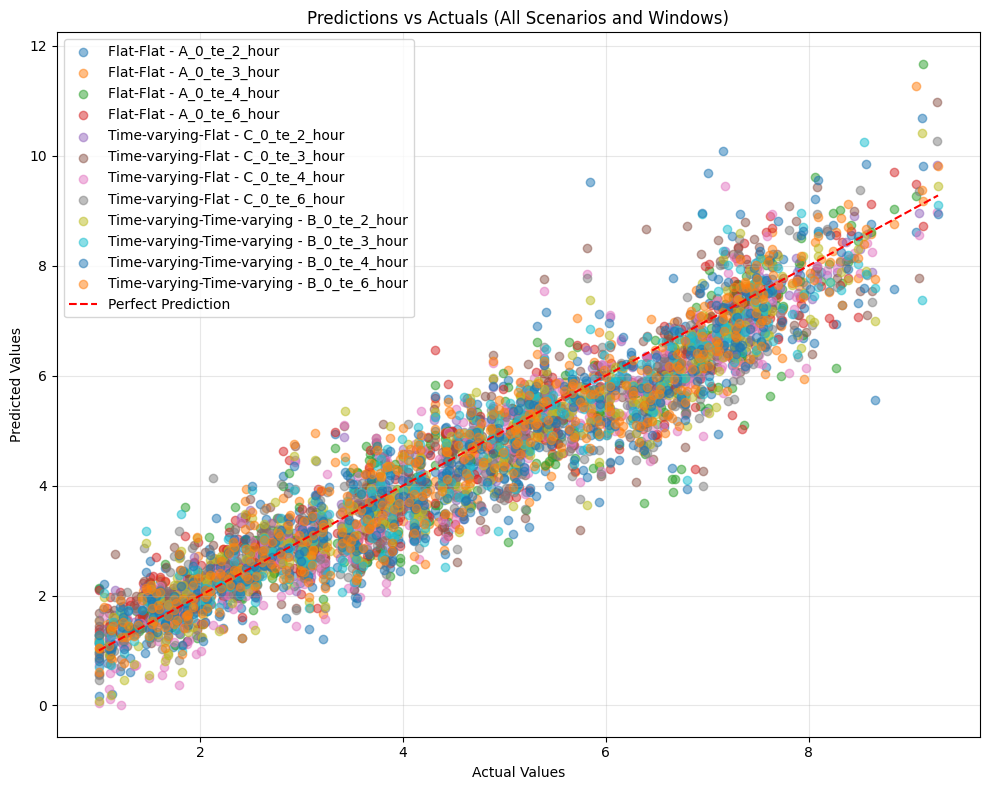

Combined plot saved to predictions_vs_actuals_plots/all_scenarios_predictions_vs_actuals.png


In [120]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined predictions and actuals file
predictions_file = "corrected_predictions.csv"
df = pd.read_csv(predictions_file)
# Remove the trailing 'h' from the Window column
df['Window'] = df['Window'].str.rstrip('h')


# Extract Scenario from the Window column
df['Scenario'] = df['Window'].str.extract(r'(A_0_te|B_0_te|C_0_te)')

# Define the mapping for scenario names
# Scenario name mapping
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}
# Replace scenario names in the DataFrame
df['Scenario'] = df['Scenario'].replace(scenario_name_mapping)

# Verify the updated scenarios
print("Unique Scenarios After Extraction and Replacement:")
print(df['Scenario'].unique())

# Directory to save the plots
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Create a single scatter plot for all scenarios and windows
plt.figure(figsize=(10, 8))
for (scenario, window), group in df.groupby(['Scenario', 'Window']):
    print(f"Plotting for Scenario: {scenario}, Window: {window}")
    plt.scatter(group['Actual'], group['Predicted'], alpha=0.5, label=f"{scenario} - {window}")

# Add the perfect prediction line
plt.plot([df['Actual'].min(), df['Actual'].max()],
         [df['Actual'].min(), df['Actual'].max()],
         'r--', label="Perfect Prediction")

# Format the plot
plt.title("Predictions vs Actuals (All Scenarios and Windows)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "all_scenarios_predictions_vs_actuals.png")
plt.savefig(plot_path)
plt.show()

print(f"Combined plot saved to {plot_path}")



In [61]:
print("Actual Value Range:", df['Actual'].min(), "to", df['Actual'].max())
print("Predicted Value Range:", df['Predicted'].min(), "to", df['Predicted'].max())

Actual Value Range: 1.0 to 9.27565005191828
Predicted Value Range: 0.013993671 to 11.660213


In [74]:
# Rebuild the model
#model = build_custom_nn(input_dim=X_val.shape[1])
#model.load_weights("path_to_saved_model_weights.h5")  # Load saved weights

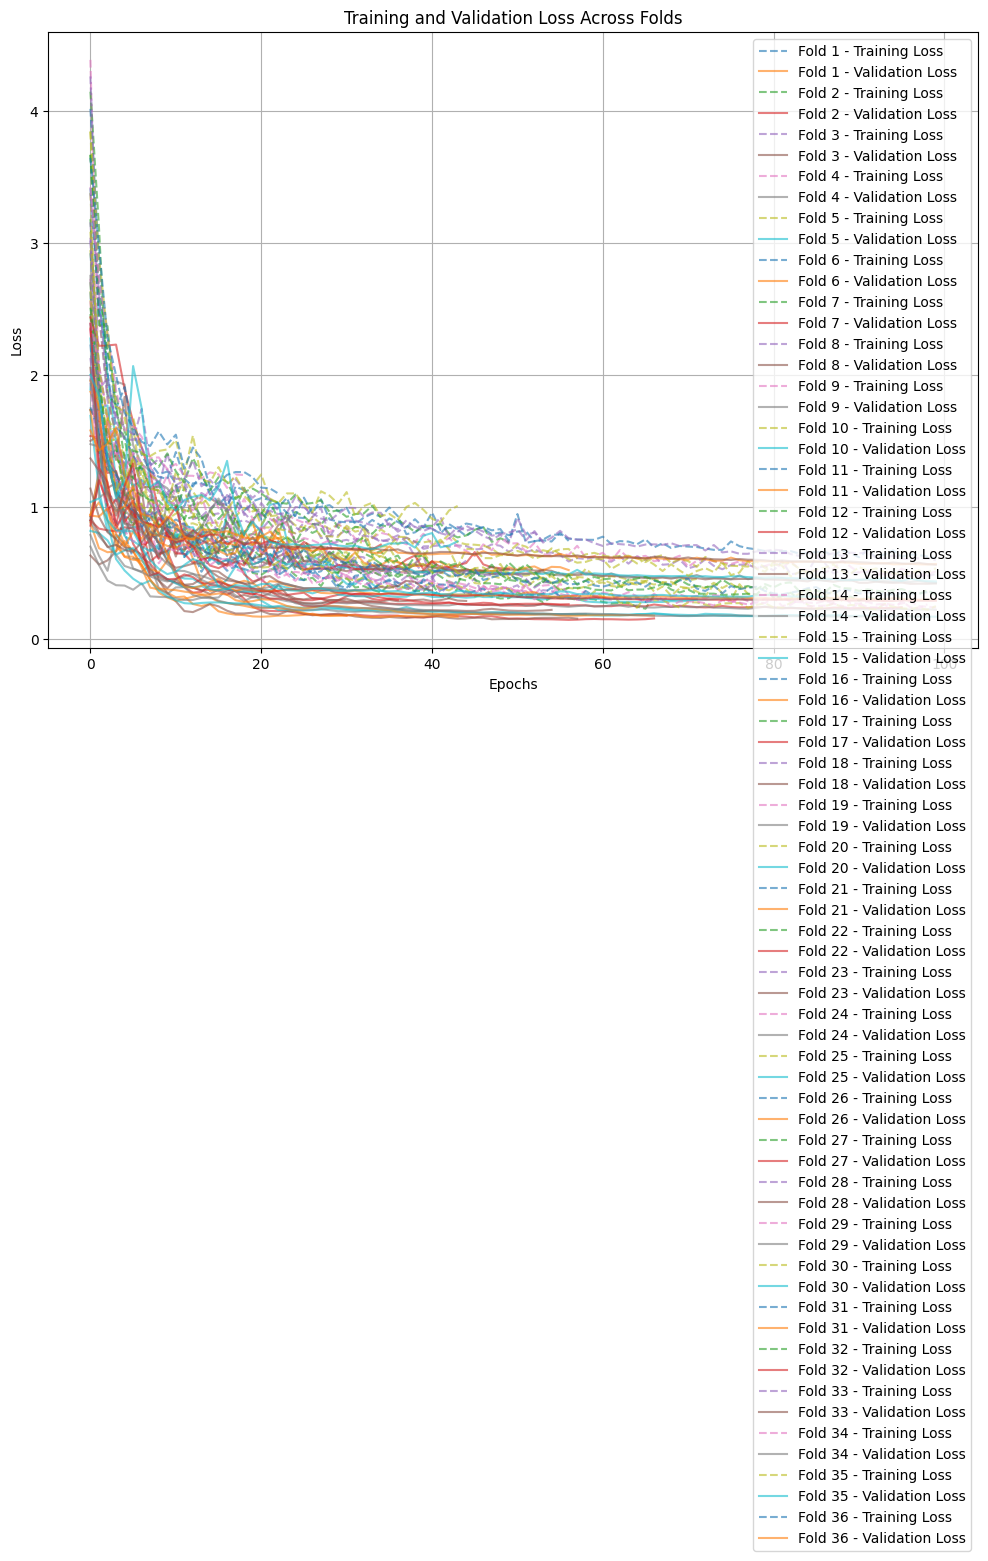

In [62]:
plt.figure(figsize=(12, 8))

for i, history in enumerate(all_fold_histories):
    plt.plot(history['loss'], label=f'Fold {i+1} - Training Loss', linestyle='--', alpha=0.6)
    plt.plot(history['val_loss'], label=f'Fold {i+1} - Validation Loss', alpha=0.6)

plt.title('Training and Validation Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Calculate residuals
df['Residual'] = df['Actual'] - df['Predicted']
print(df.columns)  # Check all column names in the DataFrame
print(df.head())   # Preview the DataFrame

Index(['House_Index', 'Actual', 'Predicted', 'Scenario', 'Window', 'Fold',
       'Original_Index', 'Residual'],
      dtype='object')
   House_Index    Actual  Predicted   Scenario         Window  Fold  \
0            0  5.462161   5.706619  Flat-Flat  A_0_te_2_hour     1   
1            1  2.972936   3.531438  Flat-Flat  A_0_te_2_hour     3   
2            2  2.820291   4.171067  Flat-Flat  A_0_te_2_hour     2   
3            3  2.137823   2.119905  Flat-Flat  A_0_te_2_hour     1   
4            4  2.707913   2.741177  Flat-Flat  A_0_te_2_hour     3   

   Original_Index  Residual  
0               0 -0.244458  
1               0 -0.558502  
2               0 -1.350776  
3               1  0.017919  
4               1 -0.033264  


In [75]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined predictions and actuals file
predictions_file = "all_combined_predictions.csv"
df = pd.read_csv(predictions_file)

# Check if Actual and Predicted columns exist
if 'Actual' in df.columns and 'Predicted' in df.columns:
    # Calculate residuals
    df['Residual'] = df['Actual'] - df['Predicted']
    print("Residual column added successfully.")
else:
    raise KeyError("Columns 'Actual' or 'Predicted' are missing.")

# Verify the updated DataFrame
print("Columns in DataFrame:", df.columns)
print("First few rows of DataFrame with Residuals:")
print(df.head())

# Group by Scenario and Window
grouped = df.groupby(['Scenario', 'Window'])

# Calculate mean and standard deviation of residuals per group
residual_stats = grouped['Residual'].agg(['mean', 'std']).reset_index()

# Save the residual statistics to a CSV
output_dir = "residual_analysis"
os.makedirs(output_dir, exist_ok=True)
residual_stats_file = os.path.join(output_dir, "residual_statistics_per_group.csv")
residual_stats.to_csv(residual_stats_file, index=False)
print("Residual statistics saved to:", residual_stats_file)


Residual column added successfully.
Columns in DataFrame: Index(['House_Index', 'Actual', 'Predicted', 'Scenario', 'Window', 'Fold',
       'Original_Index', 'Residual'],
      dtype='object')
First few rows of DataFrame with Residuals:
   House_Index    Actual  Predicted     Scenario          Window  Fold  \
0            0  5.462161   5.706619  predictions  A_0_te_2_hourh     1   
1            1  2.972936   3.531438  predictions  A_0_te_2_hourh     3   
2            2  2.820291   4.171067  predictions  A_0_te_2_hourh     2   
3            3  2.137823   2.119905  predictions  A_0_te_2_hourh     1   
4            4  2.707913   2.741177  predictions  A_0_te_2_hourh     3   

   Original_Index  Residual  
0               0 -0.244458  
1               0 -0.558502  
2               0 -1.350776  
3               1  0.017919  
4               1 -0.033264  
Residual statistics saved to: residual_analysis/residual_statistics_per_group.csv


In [65]:
residual_stats = pd.read_csv("residual_analysis/residual_statistics_per_group.csv")
print(residual_stats)

       Scenario          Window      mean       std
0   predictions  A_0_te_2_hourh  0.230528  0.652061
1   predictions  A_0_te_3_hourh  0.160745  0.551192
2   predictions  A_0_te_4_hourh  0.183605  0.706042
3   predictions  A_0_te_6_hourh  0.112349  0.669226
4   predictions  B_0_te_2_hourh  0.194517  0.610809
5   predictions  B_0_te_3_hourh  0.164185  0.587824
6   predictions  B_0_te_4_hourh  0.215182  0.722098
7   predictions  B_0_te_6_hourh  0.146911  0.586287
8   predictions  C_0_te_2_hourh  0.080118  0.455863
9   predictions  C_0_te_3_hourh  0.083289  0.742535
10  predictions  C_0_te_4_hourh  0.288498  0.663874
11  predictions  C_0_te_6_hourh  0.274539  0.692804


In [68]:
# Create a directory for group-specific plots
group_plots_dir = os.path.join(output_dir, "group_plots")
os.makedirs(group_plots_dir, exist_ok=True)

# Plot residual distribution for each Scenario and Window
for (scenario, window), group in df.groupby(['Scenario', 'Window']):
    plt.figure(figsize=(10, 6))
    sns.histplot(group['Residual'], bins=30, kde=True, color='blue', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residuals Distribution\nScenario: {scenario}, Window: {window}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    plot_file = os.path.join(group_plots_dir, f"residuals_{scenario}_{window}.png")
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved residuals plot for {scenario}, {window} to {plot_file}")


Saved residuals plot for predictions, A_0_te_2_hourh to residual_analysis/group_plots/residuals_predictions_A_0_te_2_hourh.png
Saved residuals plot for predictions, A_0_te_3_hourh to residual_analysis/group_plots/residuals_predictions_A_0_te_3_hourh.png
Saved residuals plot for predictions, A_0_te_4_hourh to residual_analysis/group_plots/residuals_predictions_A_0_te_4_hourh.png
Saved residuals plot for predictions, A_0_te_6_hourh to residual_analysis/group_plots/residuals_predictions_A_0_te_6_hourh.png
Saved residuals plot for predictions, B_0_te_2_hourh to residual_analysis/group_plots/residuals_predictions_B_0_te_2_hourh.png
Saved residuals plot for predictions, B_0_te_3_hourh to residual_analysis/group_plots/residuals_predictions_B_0_te_3_hourh.png
Saved residuals plot for predictions, B_0_te_4_hourh to residual_analysis/group_plots/residuals_predictions_B_0_te_4_hourh.png
Saved residuals plot for predictions, B_0_te_6_hourh to residual_analysis/group_plots/residuals_predictions_B_0

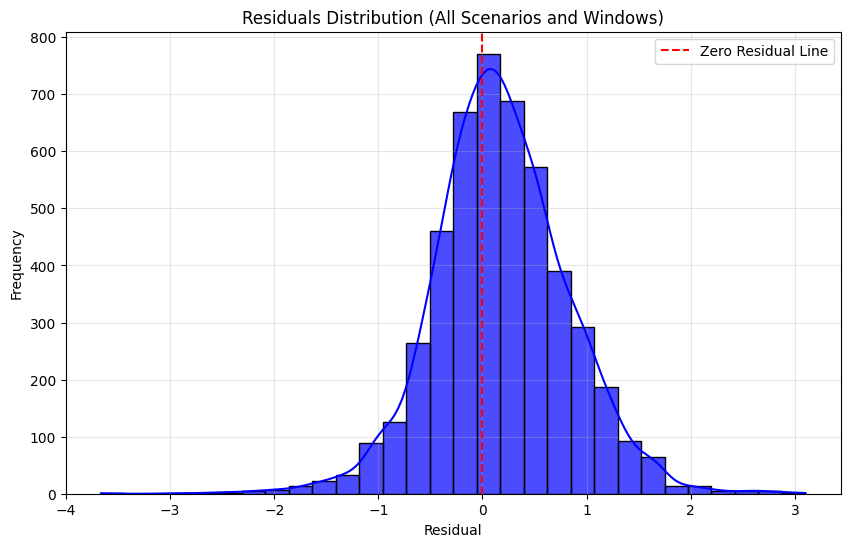

Residual distribution plot saved to residual_analysis/residual_distribution_all.png


In [76]:
import seaborn as sns

# Residuals distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Residual'], bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title("Residuals Distribution (All Scenarios and Windows)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
output_dir = "residual_analysis"
os.makedirs(output_dir, exist_ok=True)
residual_distribution_plot = os.path.join(output_dir, "residual_distribution_all.png")
plt.savefig(residual_distribution_plot)
plt.show()
print(f"Residual distribution plot saved to {residual_distribution_plot}")


In [69]:
# Plot residuals vs predicted for each Scenario and Window
for (scenario, window), group in df.groupby(['Scenario', 'Window']):
    plt.figure(figsize=(10, 6))
    plt.scatter(group['Predicted'], group['Residual'], alpha=0.5, color='green')
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residuals vs Predicted Values\nScenario: {scenario}, Window: {window}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    plot_file = os.path.join(group_plots_dir, f"residuals_vs_predicted_{scenario}_{window}.png")
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved residuals vs predicted plot for {scenario}, {window} to {plot_file}")


Saved residuals vs predicted plot for predictions, A_0_te_2_hourh to residual_analysis/group_plots/residuals_vs_predicted_predictions_A_0_te_2_hourh.png
Saved residuals vs predicted plot for predictions, A_0_te_3_hourh to residual_analysis/group_plots/residuals_vs_predicted_predictions_A_0_te_3_hourh.png
Saved residuals vs predicted plot for predictions, A_0_te_4_hourh to residual_analysis/group_plots/residuals_vs_predicted_predictions_A_0_te_4_hourh.png
Saved residuals vs predicted plot for predictions, A_0_te_6_hourh to residual_analysis/group_plots/residuals_vs_predicted_predictions_A_0_te_6_hourh.png
Saved residuals vs predicted plot for predictions, B_0_te_2_hourh to residual_analysis/group_plots/residuals_vs_predicted_predictions_B_0_te_2_hourh.png
Saved residuals vs predicted plot for predictions, B_0_te_3_hourh to residual_analysis/group_plots/residuals_vs_predicted_predictions_B_0_te_3_hourh.png
Saved residuals vs predicted plot for predictions, B_0_te_4_hourh to residual_anal

In [73]:
print(combined_predictions.columns)


RangeIndex(start=0, stop=0, step=1)


In [ ]:
#Post Analysis 

In [78]:
# Define mappings for Scenario
scenario_mapping = {
    'A_0_te': 'Flat-Flat',
    'B_0_te': 'Time-varying-Time-varying',
    'C_0_te': 'Time-varying-Flat'
}

# Extract the prefix from the Window column
df['Window_Prefix'] = df['Window'].str.extract(r'(A_0_te|B_0_te|C_0_te)')

# Debug: Verify extracted prefixes
if df['Window_Prefix'].isna().any():
    print("Some Window_Prefix values are missing:")
    print(df[df['Window_Prefix'].isna()])

# Map the Scenario column based on the Window_Prefix
df['Scenario'] = df['Window_Prefix'].map(scenario_mapping)

# Debug: Verify mapped Scenarios
if df['Scenario'].isna().any():
    print("Some Scenario values are missing:")
    print(df[df['Scenario'].isna()])

# Remove trailing 'h' from the Window column
df['Window'] = df['Window'].str.rstrip('h')

# Drop the temporary Window_Prefix column
df.drop(columns=['Window_Prefix'], inplace=True)

# Verify the changes
print("Updated DataFrame:")
print(df.head())


Updated DataFrame:
   House_Index    Actual  Predicted   Scenario         Window  Fold  \
0            0  5.462161   5.706619  Flat-Flat  A_0_te_2_hour     1   
1            1  2.972936   3.531438  Flat-Flat  A_0_te_2_hour     3   
2            2  2.820291   4.171067  Flat-Flat  A_0_te_2_hour     2   
3            3  2.137823   2.119905  Flat-Flat  A_0_te_2_hour     1   
4            4  2.707913   2.741177  Flat-Flat  A_0_te_2_hour     3   

   Original_Index  Residual  
0               0 -0.244458  
1               0 -0.558502  
2               0 -1.350776  
3               1  0.017919  
4               1 -0.033264  


In [79]:
# Save the corrected DataFrame
df.to_csv("corrected_predictions.csv", index=False)
print("Corrected DataFrame saved to 'corrected_predictions.csv'")

Corrected DataFrame saved to 'corrected_predictions.csv'


In [91]:
import os
import matplotlib.pyplot as plt

# Output directory for the plots
output_dir = "residuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Iterate through each unique combination of Scenario and Window
for scenario in df['Scenario'].unique():
    for window in df['Window'].unique():
        # Filter the DataFrame for the current Scenario and Window
        filtered_df = df[(df['Scenario'] == scenario) & (df['Window'] == window)]
        
        if not filtered_df.empty:  # Ensure there is data to plot
            plt.figure(figsize=(10, 6))
            plt.scatter(filtered_df['Predicted'], filtered_df['Residual'], alpha=0.5, color='blue')
            plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
            plt.title(f"Residuals vs Predicted Values\nScenario: {scenario}, Window: {window}")
            plt.xlabel("Predicted Values")
            plt.ylabel("Residuals")
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Save the plot
            plot_filename = f"residuals_vs_predicted_{scenario}_{window}.png".replace(" ", "_")
            plot_filepath = os.path.join(output_dir, plot_filename)
            plt.savefig(plot_filepath)
            plt.close()  # Close the plot to avoid overlapping
            
            print(f"Plot saved for Scenario: {scenario}, Window: {window} to {plot_filepath}")


Plot saved for Scenario: Flat-Flat, Window: A_0_te_2_hour to residuals_plots/residuals_vs_predicted_Flat-Flat_A_0_te_2_hour.png
Plot saved for Scenario: Flat-Flat, Window: A_0_te_3_hour to residuals_plots/residuals_vs_predicted_Flat-Flat_A_0_te_3_hour.png
Plot saved for Scenario: Flat-Flat, Window: A_0_te_6_hour to residuals_plots/residuals_vs_predicted_Flat-Flat_A_0_te_6_hour.png
Plot saved for Scenario: Flat-Flat, Window: A_0_te_4_hour to residuals_plots/residuals_vs_predicted_Flat-Flat_A_0_te_4_hour.png
Plot saved for Scenario: Time-varying-Flat, Window: C_0_te_2_hour to residuals_plots/residuals_vs_predicted_Time-varying-Flat_C_0_te_2_hour.png
Plot saved for Scenario: Time-varying-Flat, Window: C_0_te_6_hour to residuals_plots/residuals_vs_predicted_Time-varying-Flat_C_0_te_6_hour.png
Plot saved for Scenario: Time-varying-Flat, Window: C_0_te_3_hour to residuals_plots/residuals_vs_predicted_Time-varying-Flat_C_0_te_3_hour.png
Plot saved for Scenario: Time-varying-Flat, Window: C_0_

In [232]:
import os
import pandas as pd

# Define the file path
file_path = os.path.join("grid_search_results", "overall_results.csv")

# Load the dataset
df = pd.read_csv(file_path)

# Apply scenario mapping
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}
df['Tariff Structure'] = df['Scenario'].str.extract(r'^([ABC]_)')[0].map(scenario_mapping)

# Group by Tariff Structure and Window, and select the best based on the lowest MAE
best_params = df.loc[df.groupby(['Tariff Structure', 'Window'])['mae'].idxmin()]

# Select relevant columns for the summary
summary_table = best_params[['Tariff Structure', 'Window', 'num_hidden_layers', 'neurons_per_layer', 'batch_size', 'epochs']]

# Save the summary table to a CSV file
output_file = os.path.join("grid_search_results", "best_hyperparameters_summary.csv")
summary_table.to_csv(output_file, index=False)

# Print the summary table
print("Best Hyperparameters Summary:")
print(summary_table)

print(f"\nSummary table saved to {output_file}")


Best Hyperparameters Summary:
   Tariff Structure  Window  num_hidden_layers  neurons_per_layer  batch_size  \
0             FI-FE  2_hour                  2                 64          64   
1             FI-FE  3_hour                  2                128          32   
2             FI-FE  4_hour                  2                 64          32   
3             FI-FE  6_hour                  3                 64          32   
8             TI-FE  2_hour                  2                128          32   
9             TI-FE  3_hour                  3                 64          32   
10            TI-FE  4_hour                  3                 64          32   
11            TI-FE  6_hour                  2                128          32   
4             TI-TE  2_hour                  2                 32          32   
5             TI-TE  3_hour                  3                 32          32   
6             TI-TE  4_hour                  2                 64          32  

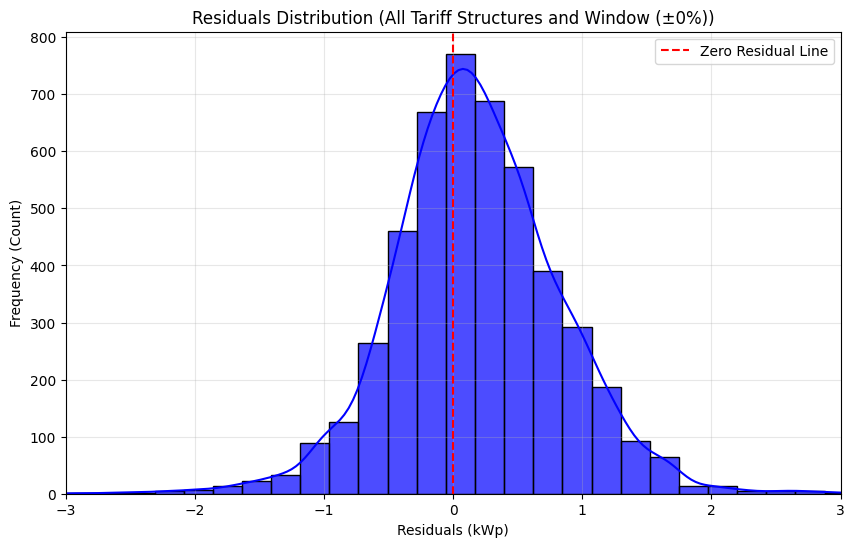

Residual distribution plot saved to residual_analysis/residual_distribution_all.png


In [135]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Residuals distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Residual'], bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title("Residuals Distribution (All Tariff Structures and Window (±0%))")
plt.xlabel("Residuals (kWp)")  # Include units if applicable
plt.ylabel("Frequency (Count)")  # Clarify that frequency is a count
plt.xlim(-3, 3)  # Set X-axis limits between -3 and 3
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
output_dir = "residual_analysis"
os.makedirs(output_dir, exist_ok=True)
residual_distribution_plot = os.path.join(output_dir, "residual_distribution_all.png")
plt.savefig(residual_distribution_plot)
plt.show()

print(f"Residual distribution plot saved to {residual_distribution_plot}")


Columns in DataFrame before cleaning: ['House_Index', 'Actual', 'Predicted', 'Scenario', 'Window', 'Fold', 'Original_Index', 'Residual']
Sample DataFrame rows:
   Residual
0 -0.244458
1 -0.558502
2 -1.350776
3  0.017919
4 -0.033264
Skewness (using pandas): 0.01925600823380485
Skewness (using scipy.stats): 0.019256008233804852


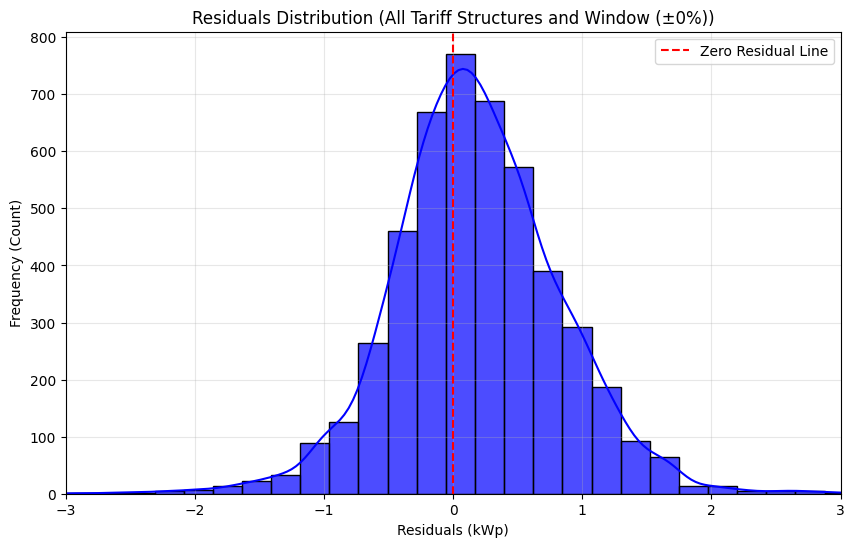

Residual distribution plot saved to residual_analysis/residual_distribution_all.png


In [218]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Load the file
df = pd.read_csv("corrected_predictions.csv")

# Debug: Check column names
print("Columns in DataFrame before cleaning:", df.columns.tolist())

# Ensure column names are clean
df.columns = df.columns.str.strip()

# Debug: Check if 'Residual' exists
if 'Residual' not in df.columns:
    raise KeyError("The 'Residual' column is missing from the DataFrame!")

# Debug: Check a sample of data
print("Sample DataFrame rows:")
print(df[['Residual']].head())

# Calculate skewness
skewness_pandas = df['Residual'].skew()
skewness_scipy = skew(df['Residual'], bias=False)

print(f"Skewness (using pandas): {skewness_pandas}")
print(f"Skewness (using scipy.stats): {skewness_scipy}")

# Residuals distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Residual'], bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title("Residuals Distribution (All Tariff Structures and Window (±0%))")
plt.xlabel("Residuals (kWp)")
plt.ylabel("Frequency (Count)")
plt.xlim(-3, 3)  # Set X-axis limits
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
output_dir = "residual_analysis"
os.makedirs(output_dir, exist_ok=True)
residual_distribution_plot = os.path.join(output_dir, "residual_distribution_all.png")
plt.savefig(residual_distribution_plot)
plt.show()

print(f"Residual distribution plot saved to {residual_distribution_plot}")



In [219]:
# Calculate skewness using pandas
skewness_pandas = df['Residual'].skew()

print(f"Skewness (using pandas): {skewness_pandas}")


Skewness (using pandas): 0.01925600823380485


In [220]:
from scipy.stats import kurtosis
kurt_value = kurtosis(df['Residual'], bias=False)
print(f"Kurtosis: {kurt_value}")


Kurtosis: 1.3476775801283658


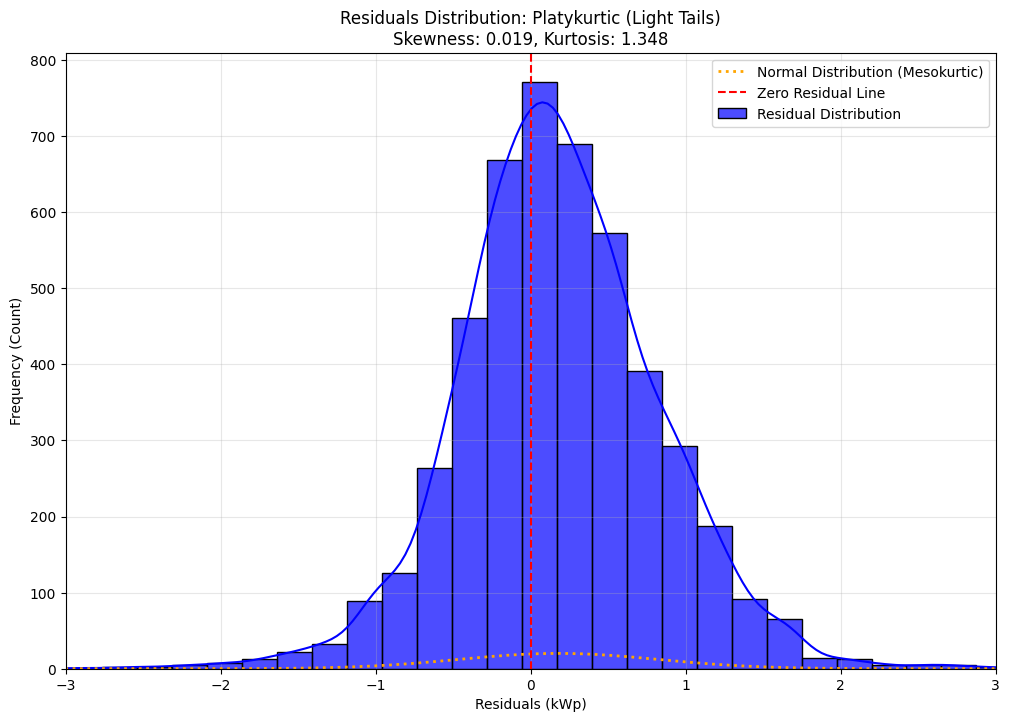

Residual distribution plot saved to residual_analysis/residual_distribution_normal_comparison.png


In [221]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis
import numpy as np

# Load the file
df = pd.read_csv("corrected_predictions.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Check if 'Residual' column exists
if 'Residual' not in df.columns:
    raise KeyError("The 'Residual' column is missing from the DataFrame!")

# Calculate statistics
mean_residual = df['Residual'].mean()
std_residual = df['Residual'].std()
skewness = df['Residual'].skew()
kurt = kurtosis(df['Residual'], bias=False)

# Generate normal distribution for comparison
x = np.linspace(df['Residual'].min(), df['Residual'].max(), 1000)
normal_curve = norm.pdf(x, mean_residual, std_residual)

# Plot the residual distribution
plt.figure(figsize=(12, 8))
sns.histplot(df['Residual'], bins=30, kde=True, color='blue', alpha=0.7, label="Residual Distribution")

# Overlay the normal distribution
plt.plot(x, normal_curve * len(df['Residual']) * (x[1] - x[0]),  # Scale to match histogram
         linestyle='dotted', color='orange', linewidth=2, label="Normal Distribution (Mesokurtic)")

# Add a vertical line at zero
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label="Zero Residual Line")

# Determine kurtosis type
if kurt < 3:
    kurtosis_type = "Platykurtic (Light Tails)"
elif kurt == 3:
    kurtosis_type = "Mesokurtic (Normal Tails)"
else:
    kurtosis_type = "Leptokurtic (Heavy Tails)"

# Add plot details
plt.title(f"Residuals Distribution: {kurtosis_type}\nSkewness: {skewness:.3f}, Kurtosis: {kurt:.3f}")
plt.xlabel("Residuals (kWp)")
plt.ylabel("Frequency (Count)")
plt.xlim(-3, 3)  # Adjust as needed
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
output_dir = "residual_analysis"
os.makedirs(output_dir, exist_ok=True)
residual_distribution_plot = os.path.join(output_dir, "residual_distribution_normal_comparison.png")
plt.savefig(residual_distribution_plot)
plt.show()

print(f"Residual distribution plot saved to {residual_distribution_plot}")


In [223]:
from scipy.stats import shapiro

stat, p_value = shapiro(df['Residual'])
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}")
if p_value > 0.05:
    print("Residuals are likely normally distributed.")
else:
    print("Residuals deviate from normality.")


Shapiro-Wilk Test Statistic: 0.9894472722909315, p-value: 1.7851386801891566e-18
Residuals deviate from normality.


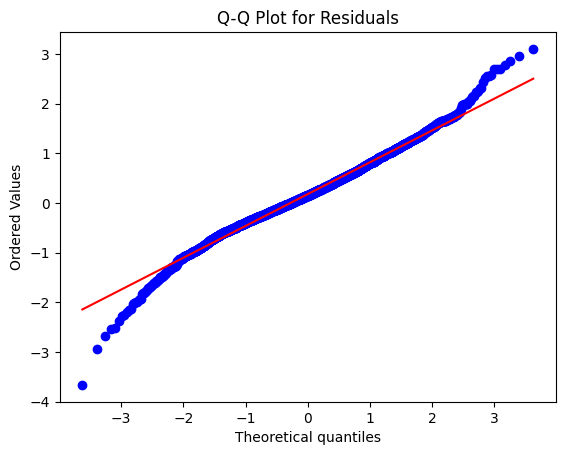

In [222]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df['Residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Residuals")
plt.show()


In [225]:
# Define thresholds for outliers
lower_threshold = -2  # Customize based on the residual range
upper_threshold = 2

# Filter outliers
filtered_df = df[(df['Residual'] >= lower_threshold) & (df['Residual'] <= upper_threshold)]

# Recalculate metrics
mae = filtered_df['Residual'].abs().mean()
rmse = (filtered_df['Residual']**2).mean()**0.5

print(f"MAE (without outliers): {mae}")
print(f"RMSE (without outliers): {rmse}")


MAE (without outliers): 0.4934131554134328
RMSE (without outliers): 0.6333078553075228


In [226]:
total_count = len(df)
outlier_count = len(df[(df['Residual'] < lower_threshold) | (df['Residual'] > upper_threshold)])
outlier_percentage = (outlier_count / total_count) * 100
print(f"Outliers make up {outlier_percentage:.2f}% of the dataset.")


Outliers make up 0.81% of the dataset.


Unique Scenarios After Extraction and Replacement:
['FI-FE' 'TI-FE' 'TI-TE']
Cleaned Window Column:
['2_hour' '4_hour' '3_hour' '6_hour']
Plotting for Scenario: FI-FE, Window: 2_hour
Plotting for Scenario: FI-FE, Window: 3_hour
Plotting for Scenario: FI-FE, Window: 4_hour
Plotting for Scenario: FI-FE, Window: 6_hour
Plotting for Scenario: TI-FE, Window: 2_hour
Plotting for Scenario: TI-FE, Window: 3_hour
Plotting for Scenario: TI-FE, Window: 4_hour
Plotting for Scenario: TI-FE, Window: 6_hour
Plotting for Scenario: TI-TE, Window: 2_hour
Plotting for Scenario: TI-TE, Window: 3_hour
Plotting for Scenario: TI-TE, Window: 4_hour
Plotting for Scenario: TI-TE, Window: 6_hour


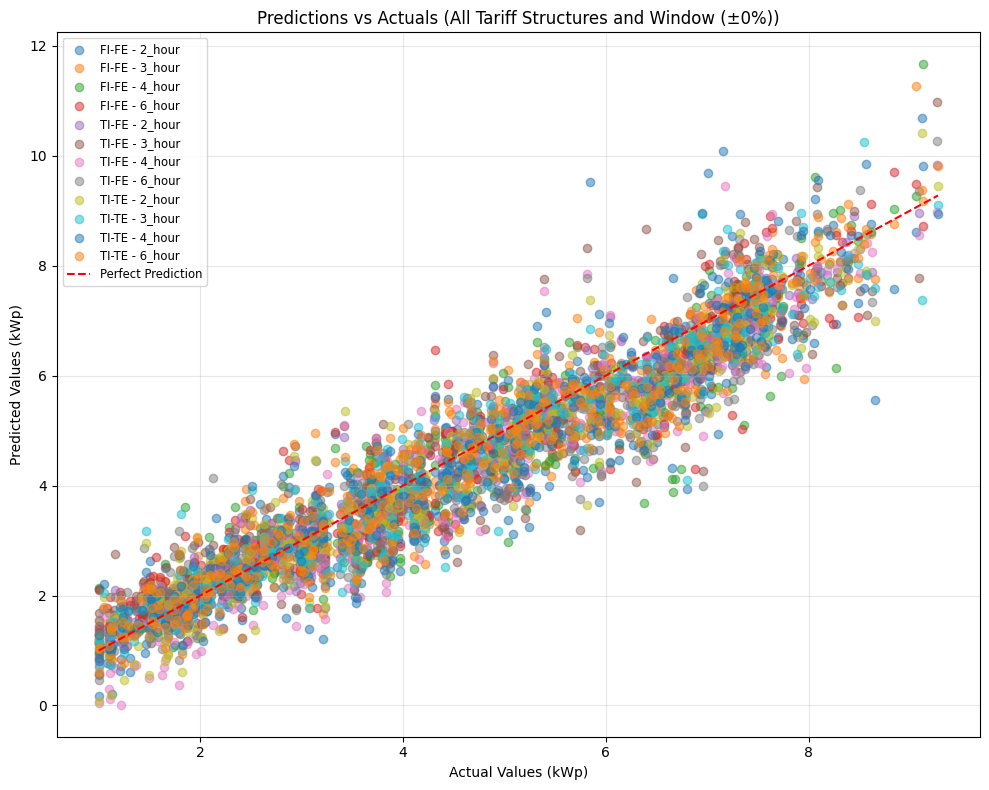

Combined plot saved to predictions_vs_actuals_plots/all_scenarios_predictions_vs_actuals.png


In [132]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined predictions and actuals file
predictions_file = "corrected_predictions.csv"
df = pd.read_csv(predictions_file)

# Extract Scenario from the original Window column before cleaning
df['Scenario'] = df['Window'].str.extract(r'^([ABC]_).*')[0]

# Define the mapping for scenario names
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}

# Replace scenario names in the DataFrame
df['Scenario'] = df['Scenario'].replace(scenario_mapping)

# Clean the Window column by removing 'A_0_te_', 'B_0_te_', 'C_0_te_'
df['Window'] = df['Window'].str.replace(r'^[ABC]_0_te_', '', regex=True)

# Debug: Verify the updated scenarios and cleaned Window column
print("Unique Scenarios After Extraction and Replacement:")
print(df['Scenario'].unique())
print("Cleaned Window Column:")
print(df['Window'].unique())

# Directory to save the plots
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Create a single scatter plot for all scenarios and windows
plt.figure(figsize=(10, 8))
for (scenario, window), group in df.groupby(['Scenario', 'Window']):
    print(f"Plotting for Scenario: {scenario}, Window: {window}")
    plt.scatter(
        group['Actual'],
        group['Predicted'],
        alpha=0.5,
        label=f"{scenario} - {window}"
    )

# Add the perfect prediction line
plt.plot(
    [df['Actual'].min(), df['Actual'].max()],
    [df['Actual'].min(), df['Actual'].max()],
    'r--',
    label="Perfect Prediction"
)

# Format the plot
plt.title("Predictions vs Actuals (All Tariff Structures and Window (±0%))")
plt.xlabel("Actual Values (kWp)")  # Add units to the X-axis
plt.ylabel("Predicted Values (kWp)")  # Add units to the Y-axis
plt.legend(fontsize='small', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "all_scenarios_predictions_vs_actuals.png")
plt.savefig(plot_path)
plt.show()

print(f"Combined plot saved to {plot_path}")


Unique Scenarios After Extraction and Replacement:
['FI-FE' 'TI-FE' 'TI-TE']
Cleaned Window Column:
['2_hour' '4_hour' '3_hour' '6_hour']
Plotting for Scenario: FI-FE, Window: 2_hour
Plotting for Scenario: FI-FE, Window: 3_hour
Plotting for Scenario: FI-FE, Window: 4_hour
Plotting for Scenario: FI-FE, Window: 6_hour
Plotting for Scenario: TI-FE, Window: 2_hour
Plotting for Scenario: TI-FE, Window: 3_hour
Plotting for Scenario: TI-FE, Window: 4_hour
Plotting for Scenario: TI-FE, Window: 6_hour
Plotting for Scenario: TI-TE, Window: 2_hour
Plotting for Scenario: TI-TE, Window: 3_hour
Plotting for Scenario: TI-TE, Window: 4_hour
Plotting for Scenario: TI-TE, Window: 6_hour


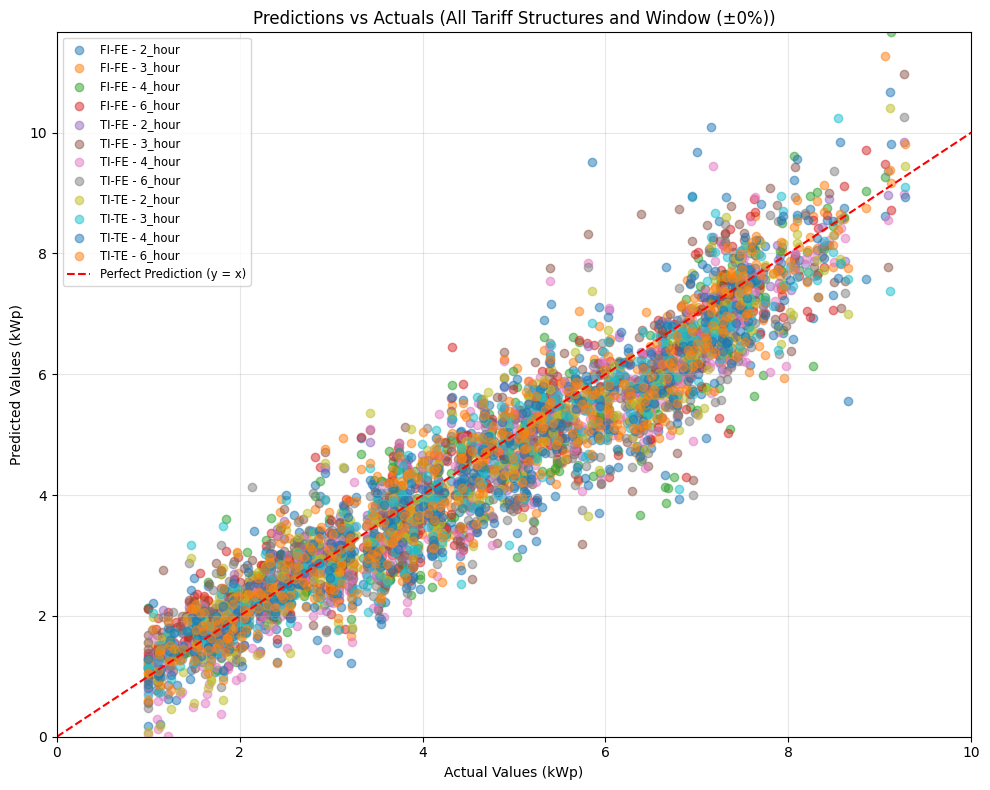

Combined plot saved to predictions_vs_actuals_plots/all_scenarios_predictions_vs_actuals.png


In [257]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined predictions and actuals file
predictions_file = "corrected_predictions.csv"
df = pd.read_csv(predictions_file)

# Extract Scenario from the original Window column before cleaning
df['Scenario'] = df['Window'].str.extract(r'^([ABC]_).*')[0]

# Define the mapping for scenario names
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}

# Replace scenario names in the DataFrame
df['Scenario'] = df['Scenario'].replace(scenario_mapping)

# Clean the Window column by removing 'A_0_te_', 'B_0_te_', 'C_0_te_'
df['Window'] = df['Window'].str.replace(r'^[ABC]_0_te_', '', regex=True)

# Debug: Verify the updated scenarios and cleaned Window column
print("Unique Scenarios After Extraction and Replacement:")
print(df['Scenario'].unique())
print("Cleaned Window Column:")
print(df['Window'].unique())

# Directory to save the plots
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Find the overall max for Actual and Predicted to define axis limits
axis_min = 0  # Force start at 0
axis_max = max(df['Actual'].max(), df['Predicted'].max())  # Find max value for scaling

# Create a single scatter plot for all scenarios and windows
plt.figure(figsize=(10, 8))
for (scenario, window), group in df.groupby(['Scenario', 'Window']):
    print(f"Plotting for Scenario: {scenario}, Window: {window}")
    plt.scatter(
        group['Actual'],
        group['Predicted'],
        alpha=0.5,
        label=f"{scenario} - {window}"
    )

# Add the perfect prediction line (y = x)
plt.plot(
    [axis_min, axis_max],
    [axis_min, axis_max],
    'r--',
    label="Perfect Prediction (y = x)"
)

# Set axis limits to start at (0, 0)
plt.xlim(axis_min, 10)
plt.ylim(axis_min, axis_max)

# Format the plot
plt.title("Predictions vs Actuals (All Tariff Structures and Window (±0%))")
plt.xlabel("Actual Values (kWp)")  # Add units to the X-axis
plt.ylabel("Predicted Values (kWp)")  # Add units to the Y-axis
plt.legend(fontsize='small', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "all_scenarios_predictions_vs_actuals.png")
plt.savefig(plot_path)
plt.show()

print(f"Combined plot saved to {plot_path}")


Plotting for Scenario: FI-FE, Window: 2_hour
Plotting for Scenario: FI-FE, Window: 3_hour
Plotting for Scenario: FI-FE, Window: 4_hour
Plotting for Scenario: FI-FE, Window: 6_hour
Plotting for Scenario: TI-FE, Window: 2_hour
Plotting for Scenario: TI-FE, Window: 3_hour
Plotting for Scenario: TI-FE, Window: 4_hour
Plotting for Scenario: TI-FE, Window: 6_hour
Plotting for Scenario: TI-TE, Window: 2_hour
Plotting for Scenario: TI-TE, Window: 3_hour
Plotting for Scenario: TI-TE, Window: 4_hour
Plotting for Scenario: TI-TE, Window: 6_hour


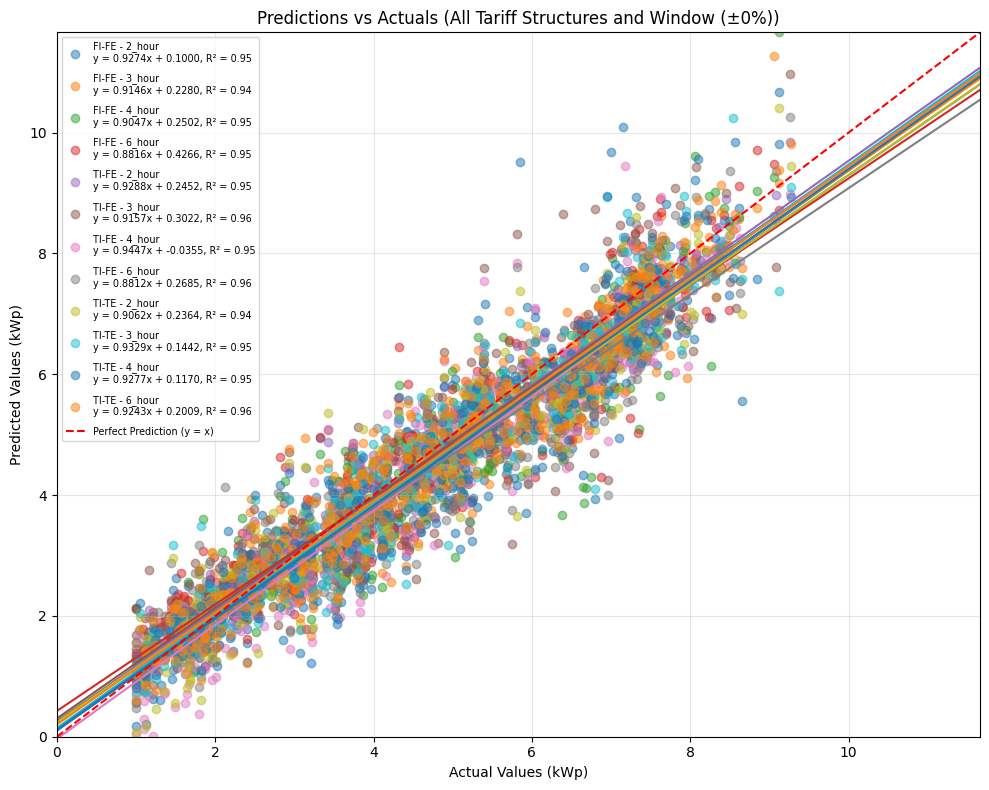

Combined plot saved to predictions_vs_actuals_plots/all_scenarios_predictions_vs_actuals_with_equation_topright.png


In [261]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the predictions and overall results files
predictions_file = "corrected_predictions.csv"
overall_results_file = "grid_search_results/overall_results.csv"

df_predictions = pd.read_csv(predictions_file)
df_overall_results = pd.read_csv(overall_results_file)

# Map scenarios in the predictions and overall results datasets
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}
overall_scenario_mapping = {
    'A_0_te': 'FI-FE',
    'B_0_te': 'TI-TE',
    'C_0_te': 'TI-FE'
}

df_predictions['Scenario'] = df_predictions['Window'].str.extract(r'^([ABC]_).*')[0].replace(scenario_mapping)
df_overall_results['Scenario'] = df_overall_results['Scenario'].replace(overall_scenario_mapping)

# Clean the 'Window' column in df_predictions
df_predictions['Cleaned_Window'] = df_predictions['Window'].str.replace(r'^[ABC]_0_te_', '', regex=True)

# Define output directory
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Find the overall max for Actual and Predicted to define axis limits
axis_min = 0  # Force start at 0
axis_max = max(df_predictions['Actual'].max(), df_predictions['Predicted'].max())  # Find max value for scaling

# Create a single scatter plot for all scenarios and windows
plt.figure(figsize=(10, 8))
unique_labels = set()  # To track unique labels and avoid duplicates

for (scenario, window), group in df_predictions.groupby(['Scenario', 'Cleaned_Window']):
    print(f"Plotting for Scenario: {scenario}, Window: {window}")

    # Fetch the provided R² value from df_overall_results
    if (scenario in df_overall_results['Scenario'].values) and (window in df_overall_results['Window'].values):
        provided_r2 = df_overall_results[
            (df_overall_results['Scenario'] == scenario) & (df_overall_results['Window'] == window)
        ]['r2'].values[0]
    else:
        provided_r2 = None

    # Perform regression to calculate slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(group['Actual'], group['Predicted'])
    equation = f"y = {slope:.4f}x + {intercept:.4f}"

    # Add to legend if not already present
    label = f"{scenario} - {window}\n{equation}, R² = {provided_r2:.2f}"
    if label not in unique_labels:
        unique_labels.add(label)  # Add to the set to track duplicates
        plt.scatter(group['Actual'], group['Predicted'], alpha=0.5, label=label)

    # Add regression line to the plot
    line_x = [axis_min, axis_max]  # Use the fixed axis limits
    line_y = [slope * x + intercept for x in line_x]
    plt.plot(line_x, line_y)

# Add the perfect prediction line (y = x)
plt.plot(
    [axis_min, axis_max],
    [axis_min, axis_max],
    'r--',
    label="Perfect Prediction (y = x)"
)

# Set axis limits to start at (0, 0)
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)

# Format the plot
plt.title("Predictions vs Actuals (All Tariff Structures and Window (±0%))")
plt.xlabel("Actual Values (kWp)")  # Add units to the X-axis
plt.ylabel("Predicted Values (kWp)")  # Add units to the Y-axis

# Position legend inside the plot at the top-right corner
plt.legend(fontsize='x-small', loc='upper left', labelspacing=1.0)

plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "all_scenarios_predictions_vs_actuals_with_equation_topright.png")
plt.savefig(plot_path, bbox_inches="tight")  # Ensure everything is included in the saved plot
plt.show()

print(f"Combined plot saved to {plot_path}")


Plotting for Scenario: FI-FE, Window: 2_hour
Plotting for Scenario: FI-FE, Window: 3_hour
Plotting for Scenario: FI-FE, Window: 4_hour
Plotting for Scenario: FI-FE, Window: 6_hour
Plotting for Scenario: TI-FE, Window: 2_hour
Plotting for Scenario: TI-FE, Window: 3_hour
Plotting for Scenario: TI-FE, Window: 4_hour
Plotting for Scenario: TI-FE, Window: 6_hour
Plotting for Scenario: TI-TE, Window: 2_hour
Plotting for Scenario: TI-TE, Window: 3_hour
Plotting for Scenario: TI-TE, Window: 4_hour
Plotting for Scenario: TI-TE, Window: 6_hour


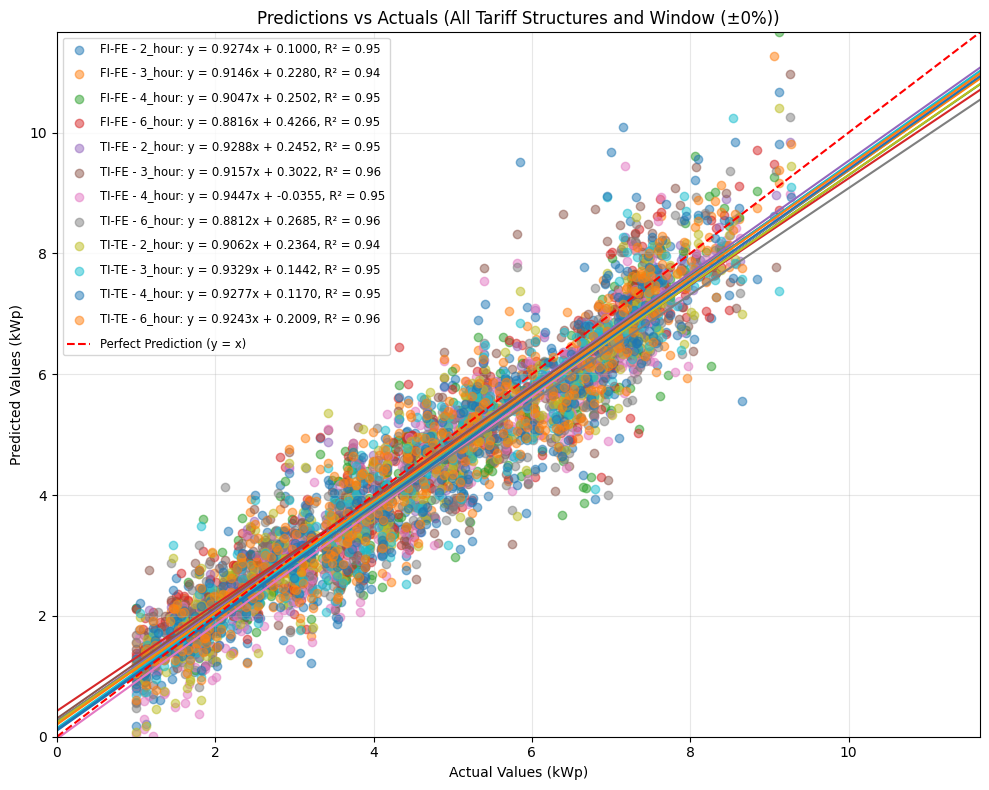

Combined plot saved to predictions_vs_actuals_plots/all_scenarios_predictions_vs_actuals_with_equation_topleft.png


In [264]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the predictions and overall results files
predictions_file = "corrected_predictions.csv"
overall_results_file = "grid_search_results/overall_results.csv"

df_predictions = pd.read_csv(predictions_file)
df_overall_results = pd.read_csv(overall_results_file)

# Map scenarios in the predictions and overall results datasets
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}
overall_scenario_mapping = {
    'A_0_te': 'FI-FE',
    'B_0_te': 'TI-TE',
    'C_0_te': 'TI-FE'
}

df_predictions['Scenario'] = df_predictions['Window'].str.extract(r'^([ABC]_).*')[0].replace(scenario_mapping)
df_overall_results['Scenario'] = df_overall_results['Scenario'].replace(overall_scenario_mapping)

# Clean the 'Window' column in df_predictions
df_predictions['Cleaned_Window'] = df_predictions['Window'].str.replace(r'^[ABC]_0_te_', '', regex=True)

# Define output directory
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Find the overall max for Actual and Predicted to define axis limits
axis_min = 0  # Force start at 0
axis_max = max(df_predictions['Actual'].max(), df_predictions['Predicted'].max())  # Find max value for scaling

# Create a single scatter plot for all scenarios and windows
plt.figure(figsize=(10, 8))
unique_labels = set()  # To track unique labels and avoid duplicates

for (scenario, window), group in df_predictions.groupby(['Scenario', 'Cleaned_Window']):
    print(f"Plotting for Scenario: {scenario}, Window: {window}")

    # Fetch the provided R² value from df_overall_results
    if (scenario in df_overall_results['Scenario'].values) and (window in df_overall_results['Window'].values):
        provided_r2 = df_overall_results[
            (df_overall_results['Scenario'] == scenario) & (df_overall_results['Window'] == window)
        ]['r2'].values[0]
    else:
        provided_r2 = None

    # Perform regression to calculate slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(group['Actual'], group['Predicted'])
    intercept_sign = "+" if intercept >= 0 else "-"

    equation = f"y = {slope:.4f}x + {intercept:.4f}"

    # Combine the scenario, window, equation, and R² in a single line
    label = f"{scenario} - {window}: {equation}, R² = {provided_r2:.2f}"

    # Add to legend if not already present
    if label not in unique_labels:
        unique_labels.add(label)  # Add to the set to track duplicates
        plt.scatter(group['Actual'], group['Predicted'], alpha=0.5, label=label)

    # Add regression line to the plot
    line_x = [axis_min, axis_max]  # Use the fixed axis limits
    line_y = [slope * x + intercept for x in line_x]
    plt.plot(line_x, line_y)

# Add the perfect prediction line (y = x)
plt.plot(
    [axis_min, axis_max],
    [axis_min, axis_max],
    'r--',
    label="Perfect Prediction (y = x)"
)

# Set axis limits to start at (0, 0)
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)

# Format the plot
plt.title("Predictions vs Actuals (All Tariff Structures and Window (±0%))")
plt.xlabel("Actual Values (kWp)")  # Add units to the X-axis
plt.ylabel("Predicted Values (kWp)")  # Add units to the Y-axis

# Position legend inside the plot at the top-left corner
plt.legend(
    fontsize='small',
    loc='upper left',
    labelspacing=1.0  # Adjust spacing between entries
)

plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "all_scenarios_predictions_vs_actuals_with_equation_topleft.png")
plt.savefig(plot_path, bbox_inches="tight")  # Ensure everything is included in the saved plot
plt.show()

print(f"Combined plot saved to {plot_path}")


Plotting for Scenario: FI-FE, Window: 2_hour
Plotting for Scenario: FI-FE, Window: 3_hour
Plotting for Scenario: FI-FE, Window: 4_hour
Plotting for Scenario: FI-FE, Window: 6_hour
Plotting for Scenario: TI-FE, Window: 2_hour
Plotting for Scenario: TI-FE, Window: 3_hour
Plotting for Scenario: TI-FE, Window: 4_hour
Plotting for Scenario: TI-FE, Window: 6_hour
Plotting for Scenario: TI-TE, Window: 2_hour
Plotting for Scenario: TI-TE, Window: 3_hour
Plotting for Scenario: TI-TE, Window: 4_hour
Plotting for Scenario: TI-TE, Window: 6_hour


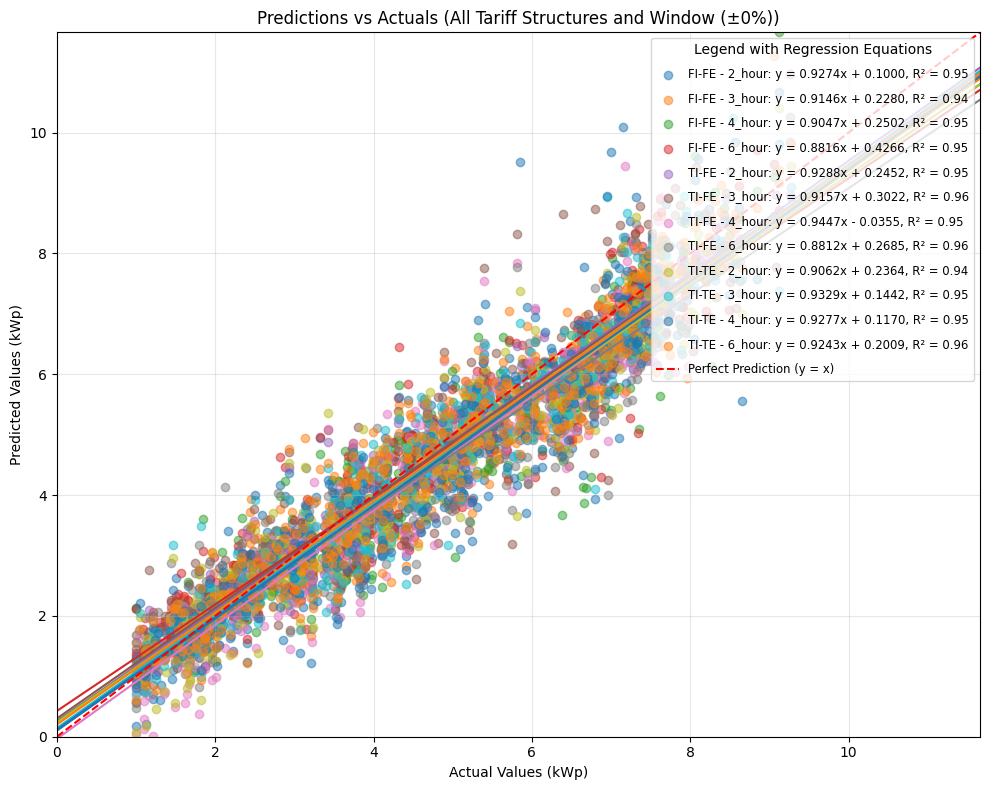

Combined plot saved to predictions_vs_actuals_plots/all_scenarios_predictions_vs_actuals_with_equation_topright.png


In [267]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the predictions and overall results files
predictions_file = "corrected_predictions.csv"
overall_results_file = "grid_search_results/overall_results.csv"

df_predictions = pd.read_csv(predictions_file)
df_overall_results = pd.read_csv(overall_results_file)

# Map scenarios in the predictions and overall results datasets
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}
overall_scenario_mapping = {
    'A_0_te': 'FI-FE',
    'B_0_te': 'TI-TE',
    'C_0_te': 'TI-FE'
}

df_predictions['Scenario'] = df_predictions['Window'].str.extract(r'^([ABC]_).*')[0].replace(scenario_mapping)
df_overall_results['Scenario'] = df_overall_results['Scenario'].replace(overall_scenario_mapping)

# Clean the 'Window' column in df_predictions
df_predictions['Cleaned_Window'] = df_predictions['Window'].str.replace(r'^[ABC]_0_te_', '', regex=True)

# Define output directory
output_dir = "predictions_vs_actuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Find the overall max for Actual and Predicted to define axis limits
axis_min = 0  # Force start at 0
axis_max = max(df_predictions['Actual'].max(), df_predictions['Predicted'].max())  # Find max value for scaling

# Create a single scatter plot for all scenarios and windows
plt.figure(figsize=(10, 8))
unique_labels = set()  # To track unique labels and avoid duplicates

for (scenario, window), group in df_predictions.groupby(['Scenario', 'Cleaned_Window']):
    print(f"Plotting for Scenario: {scenario}, Window: {window}")

    # Fetch the provided R² value from df_overall_results
    r2_rows = df_overall_results[
        (df_overall_results['Scenario'] == scenario) & (df_overall_results['Window'] == window)
    ]

    if not r2_rows.empty:
        provided_r2 = r2_rows['r2'].values[0]
    else:
        provided_r2 = None  # If no match, this will avoid crashes

    # Perform regression to calculate slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(group['Actual'], group['Predicted'])

    # Explicitly format the intercept with ± sign
    intercept_sign = "+" if intercept >= 0 else "-"
    equation = f"y = {slope:.4f}x {intercept_sign} {abs(intercept):.4f}"

    # Format R² value
    r2_text = f"{provided_r2:.2f}" if provided_r2 is not None else "N/A"

    # Combine the scenario, window, equation, and R² in a single line
    label = f"{scenario} - {window}: {equation}, R² = {r2_text}"

    # Add to legend if not already present
    if label not in unique_labels:
        unique_labels.add(label)  # Add to the set to track duplicates
        plt.scatter(group['Actual'], group['Predicted'], alpha=0.5, label=label)

    # Add regression line to the plot
    line_x = [axis_min, axis_max]  # Use the fixed axis limits
    line_y = [slope * x + intercept for x in line_x]
    plt.plot(line_x, line_y)

# Add the perfect prediction line (y = x)
plt.plot(
    [axis_min, axis_max],
    [axis_min, axis_max],
    'r--',
    label="Perfect Prediction (y = x)"
)

# Set axis limits to start at (0, 0)
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)

# Format the plot
plt.title("Predictions vs Actuals (All Tariff Structures and Window (±0%))")
plt.xlabel("Actual Values (kWp)")  # Add units to the X-axis
plt.ylabel("Predicted Values (kWp)")  # Add units to the Y-axis

# Position legend inside the plot at the top-right corner
plt.legend(
    fontsize='small',
    loc='upper right',
    title="Legend with Regression Equations",
    labelspacing=1.0  # Adjust spacing between entries
)

plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "all_scenarios_predictions_vs_actuals_with_equation_topright.png")
plt.savefig(plot_path, bbox_inches="tight")  # Ensure everything is included in the saved plot
plt.show()

print(f"Combined plot saved to {plot_path}")


Columns in DataFrame before processing: Index(['House_Index', 'Actual', 'Predicted', 'Scenario', 'Window', 'Fold',
       'Original_Index', 'Residual'],
      dtype='object')
Unique values in 'Scenario' before mapping: ['Flat-Flat' 'Time-varying-Flat' 'Time-varying-Time-varying']
Unique values in 'Scenario' after mapping: ['FI-FE' 'TI-FE' 'TI-TE']
Cleaned Window column unique values: ['2_hour' '4_hour' '3_hour' '6_hour']


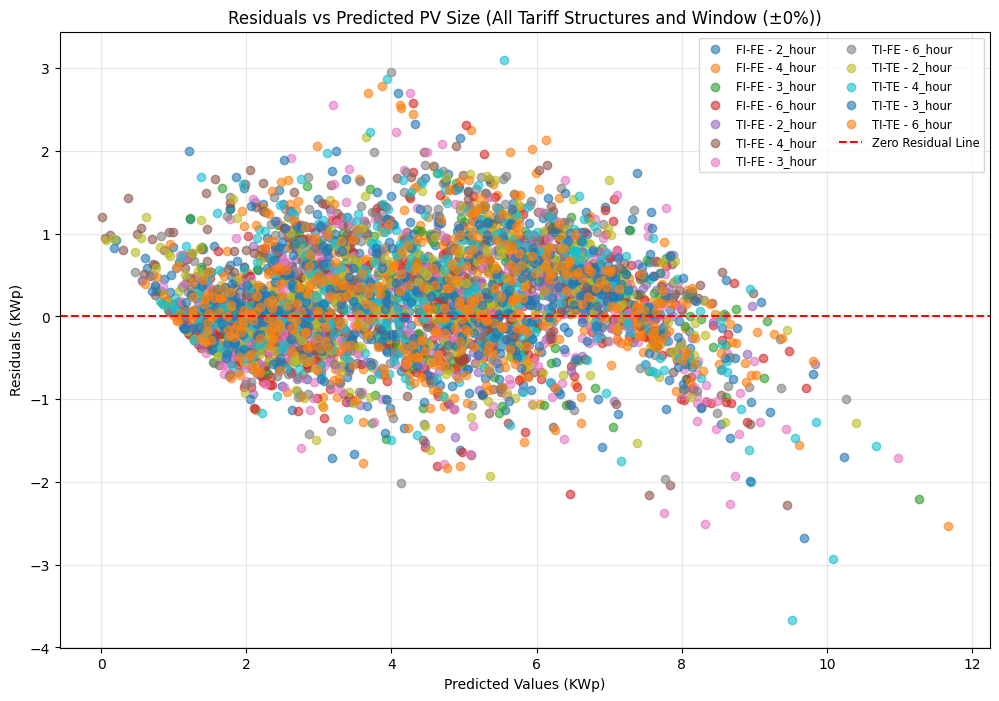

Combined Residuals vs Predicted plot saved to residuals_plots/residuals_vs_predicted_combined_cleaned.png


In [166]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the file
predictions_file = "corrected_predictions.csv"
df = pd.read_csv(predictions_file)

# Debug: Check the DataFrame columns
print("Columns in DataFrame before processing:", df.columns)

# Step 1: Verify if 'Scenario' exists
if 'Scenario' not in df.columns:
    print("'Scenario' column is missing. Recreating it...")
    scenario_mapping = {
        'A_': 'Flat-Flat',
        'B_': 'Time-varying-Time-varying',
        'C_': 'Time-varying-Flat'
    }
    # Extract Scenario information from 'Window' if applicable
    df['Scenario'] = df['Window'].str.extract(r'^([ABC]_).*')[0].replace(scenario_mapping)

# Debug: Check unique values in the 'Scenario' column
print("Unique values in 'Scenario' before mapping:", df['Scenario'].unique())

# Step 2: Replace Scenario values with updated mappings
df['Scenario'] = df['Scenario'].replace({
    'Flat-Flat': 'FI-FE',
    'Time-varying-Time-varying': 'TI-TE',
    'Time-varying-Flat': 'TI-FE'
})

# Debug: Check unique values after mapping
print("Unique values in 'Scenario' after mapping:", df['Scenario'].unique())

# Step 3: Clean the 'Window' column
df['Cleaned_Window'] = (
    df['Window']
    .str.replace(r'^[A-Z]_[0-9]_te_', '', regex=True)  # Remove prefixes like A_0_te_
    .str.replace(r'te_', '', regex=True)               # Remove any "te_" left
    .str.replace(r'0_', '', regex=True)                # Remove "0_"
    .str.strip()                                       # Strip leading/trailing spaces
)

# Debug: Check cleaned Window values
print("Cleaned Window column unique values:", df['Cleaned_Window'].unique())

# Step 4: Plot setup
plt.figure(figsize=(12, 8))

# Iterate through each unique combination of Scenario and Cleaned Window
for scenario in df['Scenario'].unique():
    for window in df['Cleaned_Window'].unique():
        # Filter the DataFrame for the current Scenario and Cleaned Window
        filtered_df = df[(df['Scenario'] == scenario) & (df['Cleaned_Window'] == window)]
        if not filtered_df.empty:
            plt.scatter(
                filtered_df['Predicted'],
                filtered_df['Residual'],
                alpha=0.6,
                label=f"{scenario} - {window}",
            )

# Add plot details
plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title("Residuals vs Predicted PV Size (All Tariff Structures and Window (±0%))")
plt.xlabel("Predicted Values (KWp)")
plt.ylabel("Residuals (KWp)")
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True, alpha=0.3)

# Step 5: Save the plot
output_dir = "residuals_plots"
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, "residuals_vs_predicted_combined_cleaned.png")
plt.savefig(plot_file)
plt.show()

print(f"Combined Residuals vs Predicted plot saved to {plot_file}")


Columns in DataFrame before processing: Index(['House_Index', 'Actual', 'Predicted', 'Scenario', 'Window', 'Fold',
       'Original_Index', 'Residual'],
      dtype='object')
Unique values in 'Scenario' before mapping: ['Flat-Flat' 'Time-varying-Flat' 'Time-varying-Time-varying']
Unique values in 'Scenario' after mapping: ['FI-FE' 'TI-FE' 'TI-TE']
Cleaned Window column unique values: ['2_hour' '4_hour' '3_hour' '6_hour']


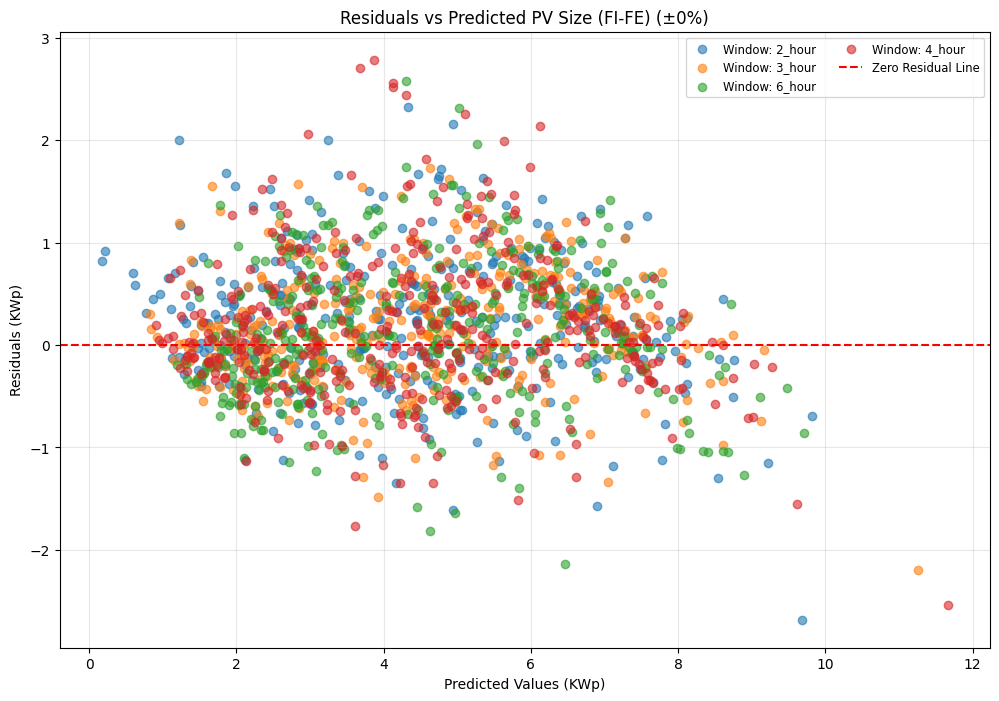

Residuals vs Predicted plot saved for FI-FE to residuals_plots/residuals_vs_predicted_FI-FE.png


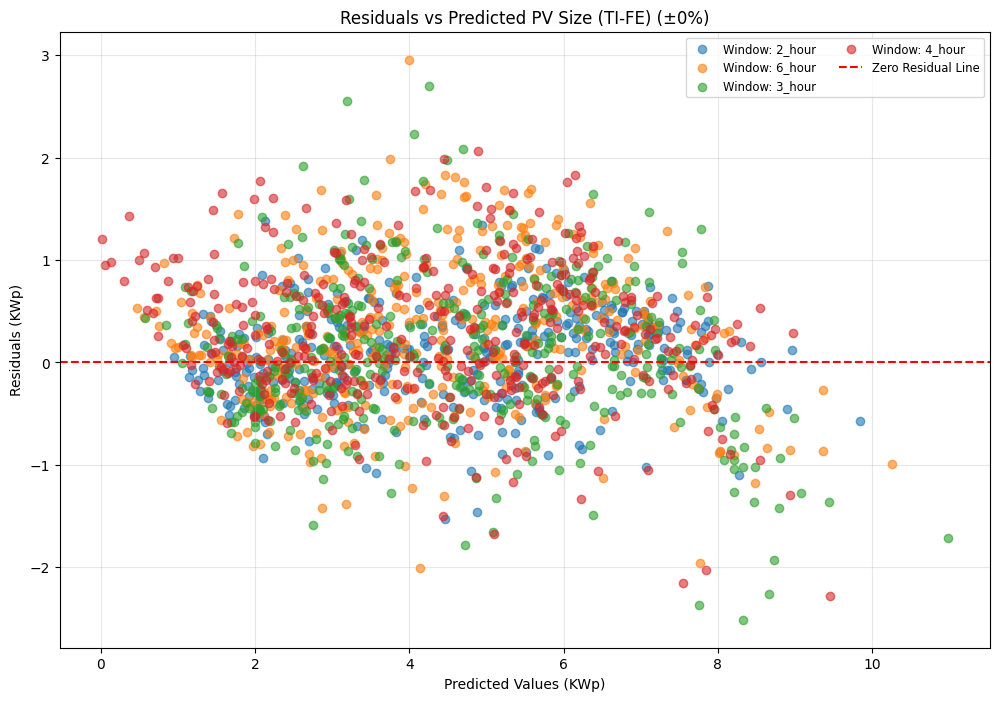

Residuals vs Predicted plot saved for TI-FE to residuals_plots/residuals_vs_predicted_TI-FE.png


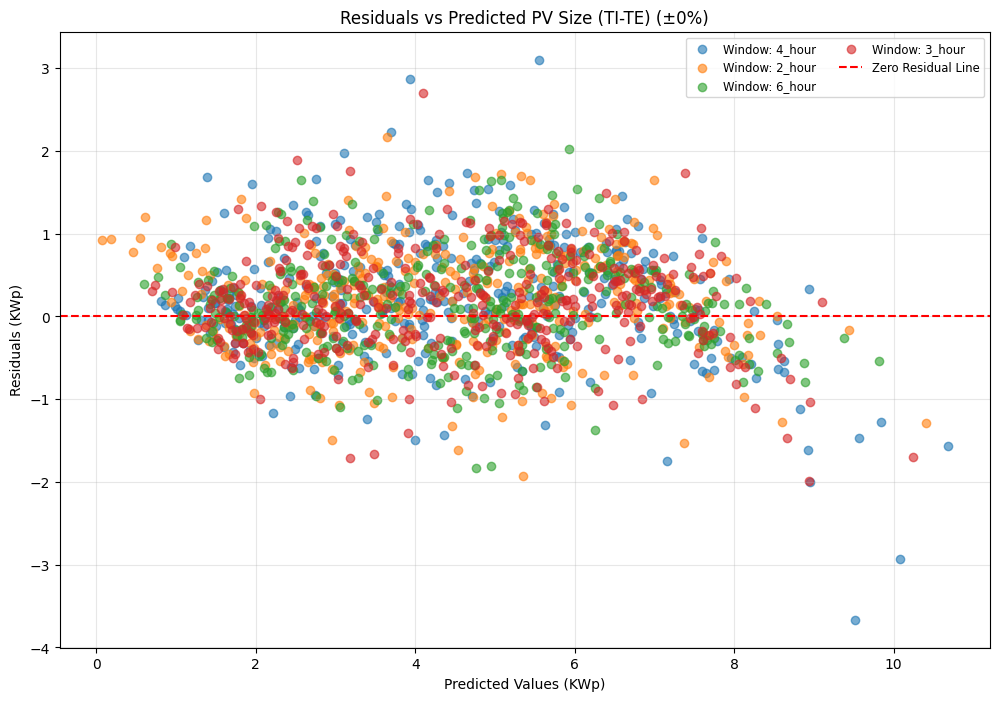

Residuals vs Predicted plot saved for TI-TE to residuals_plots/residuals_vs_predicted_TI-TE.png


In [164]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
predictions_file = "corrected_predictions.csv"
df = pd.read_csv(predictions_file)

# Debug: Check the DataFrame columns
print("Columns in DataFrame before processing:", df.columns)

# Step 1: Verify if 'Scenario' exists
if 'Scenario' not in df.columns:
    print("'Scenario' column is missing. Recreating it...")
    scenario_mapping = {
        'A_': 'Flat-Flat',
        'B_': 'Time-varying-Time-varying',
        'C_': 'Time-varying-Flat'
    }
    # Extract Scenario information from 'Window' if applicable
    df['Scenario'] = df['Window'].str.extract(r'^([ABC]_).*')[0].replace(scenario_mapping)

# Debug: Check unique values in the 'Scenario' column
print("Unique values in 'Scenario' before mapping:", df['Scenario'].unique())

# Step 2: Replace Scenario values with updated mappings
df['Scenario'] = df['Scenario'].replace({
    'Flat-Flat': 'FI-FE',
    'Time-varying-Time-varying': 'TI-TE',
    'Time-varying-Flat': 'TI-FE'
})

# Debug: Check unique values after mapping
print("Unique values in 'Scenario' after mapping:", df['Scenario'].unique())

# Step 3: Clean the 'Window' column
df['Cleaned_Window'] = (
    df['Window']
    .str.replace(r'^[A-Z]_[0-9]+_te_', '', regex=True)  # Remove prefixes like A_0_te_
    .str.replace(r'te_', '', regex=True)               # Remove any "te_" left
    .str.replace(r'0_', '', regex=True)                # Remove "0_"
    .str.strip()                                       # Strip leading/trailing spaces
)

# Debug: Check cleaned Window values
print("Cleaned Window column unique values:", df['Cleaned_Window'].unique())

# Directory to save the individual plots
output_dir = "residuals_plots"
os.makedirs(output_dir, exist_ok=True)

# Step 4: Generate separate plots for each Scenario
for scenario in df['Scenario'].unique():
    plt.figure(figsize=(12, 8))
    scenario_df = df[df['Scenario'] == scenario]

    for window in scenario_df['Cleaned_Window'].unique():
        filtered_df = scenario_df[scenario_df['Cleaned_Window'] == window]
        if not filtered_df.empty:
            plt.scatter(
                filtered_df['Predicted'],
                filtered_df['Residual'],
                alpha=0.6,
                label=f"Window: {window}",
            )

    # Add plot details
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residuals vs Predicted PV Size ({scenario}) (±0%)")
    plt.xlabel("Predicted Values (KWp)")
    plt.ylabel("Residuals (KWp)")
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.grid(True, alpha=0.3)

    # Save the plot
    plot_file = os.path.join(output_dir, f"residuals_vs_predicted_{scenario}.png")
    plt.savefig(plot_file)
    plt.show()

    print(f"Residuals vs Predicted plot saved for {scenario} to {plot_file}")


Aggregated Metrics by Scenario and Window (Cleaned):
   Scenario  Window       mae       mse        r2
0     FI-FE  2_hour  0.390090  0.255699  0.940145
1     FI-FE  3_hour  0.375670  0.218473  0.948764
2     FI-FE  4_hour  0.387260  0.238830  0.943943
3     FI-FE  6_hour  0.385259  0.232554  0.945586
4     TI-FE  2_hour  0.366449  0.213657  0.949496
5     TI-FE  3_hour  0.345958  0.190302  0.954984
6     TI-FE  4_hour  0.355912  0.203634  0.951657
7     TI-FE  6_hour  0.330348  0.172963  0.958915
8     TI-TE  2_hour  0.385023  0.216665  0.948807
9     TI-TE  3_hour  0.379453  0.243825  0.942187
10    TI-TE  4_hour  0.351501  0.213026  0.950068
11    TI-TE  6_hour  0.334815  0.180187  0.957454


<Figure size 1200x600 with 0 Axes>

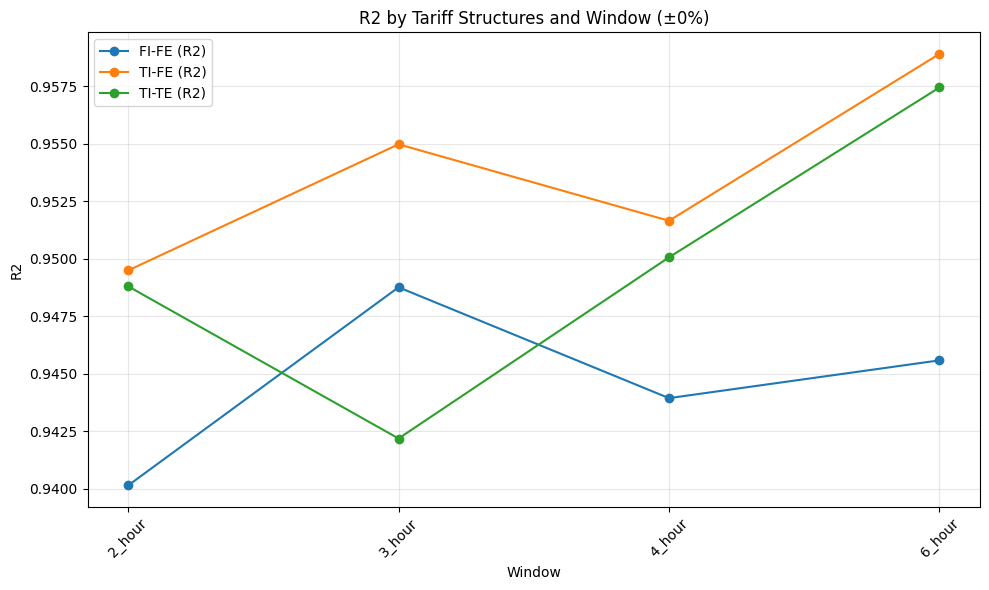

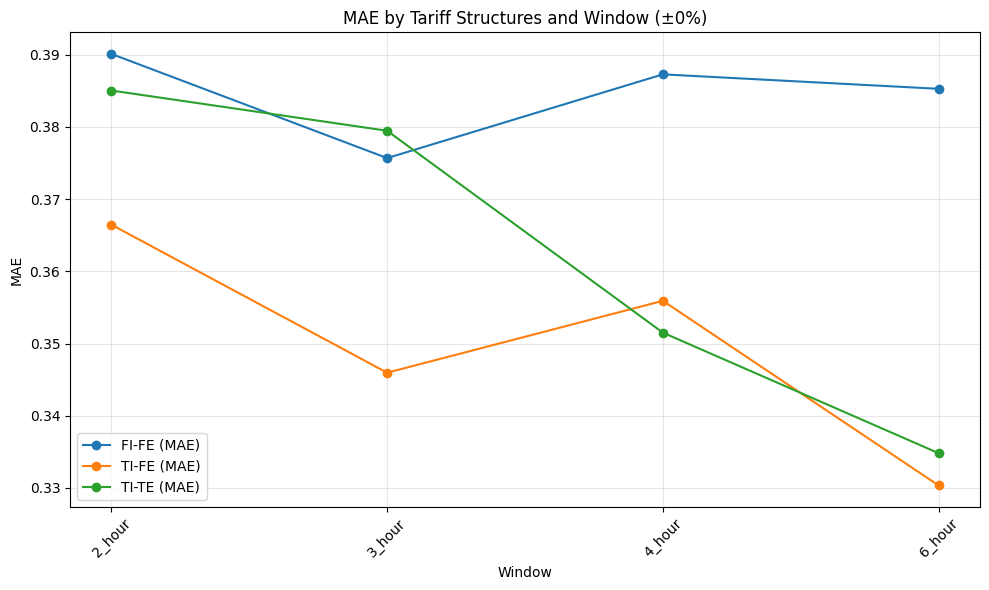

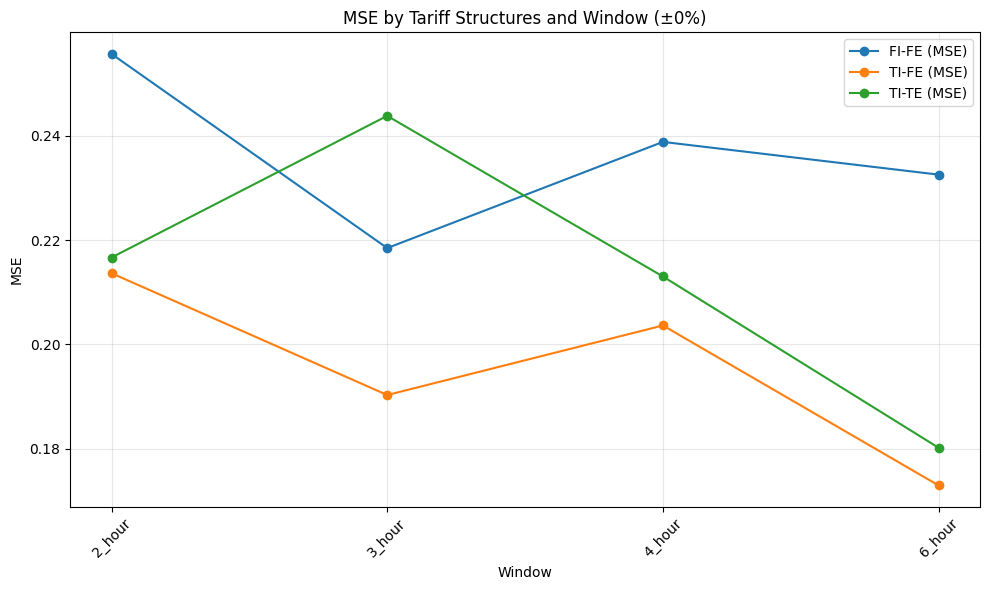

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics file
metrics_file = "grid_search_results/overall_results.csv"  # Replace with your actual file path
metrics_df = pd.read_csv(metrics_file)

# Scenario name mapping
scenario_mapping = {
    'A_': 'FI-FE',
    'B_': 'TI-TE',
    'C_': 'TI-FE'
}

# Adjust Scenario names and remove any trailing "0" or extra characters
metrics_df['Scenario'] = (
    metrics_df['Scenario']
    .replace(scenario_mapping, regex=True)  # Replace A_, B_, C_ with readable names
    .str.replace('_te', '', regex=True)    # Remove "_te"
    .str.replace('0', '', regex=True)      # Remove trailing "0"
    .str.strip()                           # Remove any leading/trailing spaces
)

# Clean the Window column to remove "_te" or similar patterns
metrics_df['Window'] = (
    metrics_df['Window']
    .str.replace('_te', '', regex=True)  # Remove "_te"
    .str.strip()                         # Remove any leading/trailing spaces
)

# Group by Scenario and Window, and calculate average metrics
aggregated_metrics = metrics_df.groupby(['Scenario', 'Window']).agg({
    'mae': 'mean',
    'mse': 'mean',
    'r2': 'mean'
}).reset_index()

# Sort by Scenario and Window
aggregated_metrics = aggregated_metrics.sort_values(by=['Scenario', 'Window'])

# Save to a new CSV file for comparison
output_file = "aggregated_metrics_by_scenario_and_window_cleaned.csv"
aggregated_metrics.to_csv(output_file, index=False)

# Display the cleaned and aggregated results
print("Aggregated Metrics by Scenario and Window (Cleaned):")
print(aggregated_metrics)

# Optional: Visualization
plt.figure(figsize=(12, 6))

# Plot metrics for each Scenario and Window
for metric, color in zip(['r2', 'mae', 'mse'], ['green', 'blue', 'orange']):
    plt.figure(figsize=(10, 6))
    for scenario in aggregated_metrics['Scenario'].unique():
        subset = aggregated_metrics[aggregated_metrics['Scenario'] == scenario]
        plt.plot(
            subset['Window'],
            subset[metric],
            marker='o',
            label=f"{scenario} ({metric.upper()})"
        )
    plt.title(f"{metric.upper()} by Tariff Structures and Window (±0%)")
    plt.xlabel("Window")
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Original Window column unique values (before cleaning):
['A_0_te_2_hour' 'C_0_te_2_hour' 'B_0_te_4_hour' 'A_0_te_3_hour'
 'A_0_te_6_hour' 'B_0_te_2_hour' 'C_0_te_6_hour' 'A_0_te_4_hour'
 'B_0_te_6_hour' 'C_0_te_3_hour' 'B_0_te_3_hour' 'C_0_te_4_hour']
Cleaned Window column unique values (after cleaning):
['2_hour' '4_hour' '3_hour' '6_hour']
Columns in DataFrame: Index(['House_Index', 'Actual', 'Predicted', 'Window', 'Fold',
       'Original_Index', 'Residual', 'Tariff Structures'],
      dtype='object')
First few rows of DataFrame:
   House_Index    Actual  Predicted  Window  Fold  Original_Index  Residual  \
0            0  5.462161   5.706619  2_hour     1               0 -0.244458   
1            1  2.972936   3.531438  2_hour     3               0 -0.558502   
2            2  2.820291   4.171067  2_hour     2               0 -1.350776   
3            3  2.137823   2.119905  2_hour     1               1  0.017919   
4            4  2.707913   2.741177  2_hour     3               1 

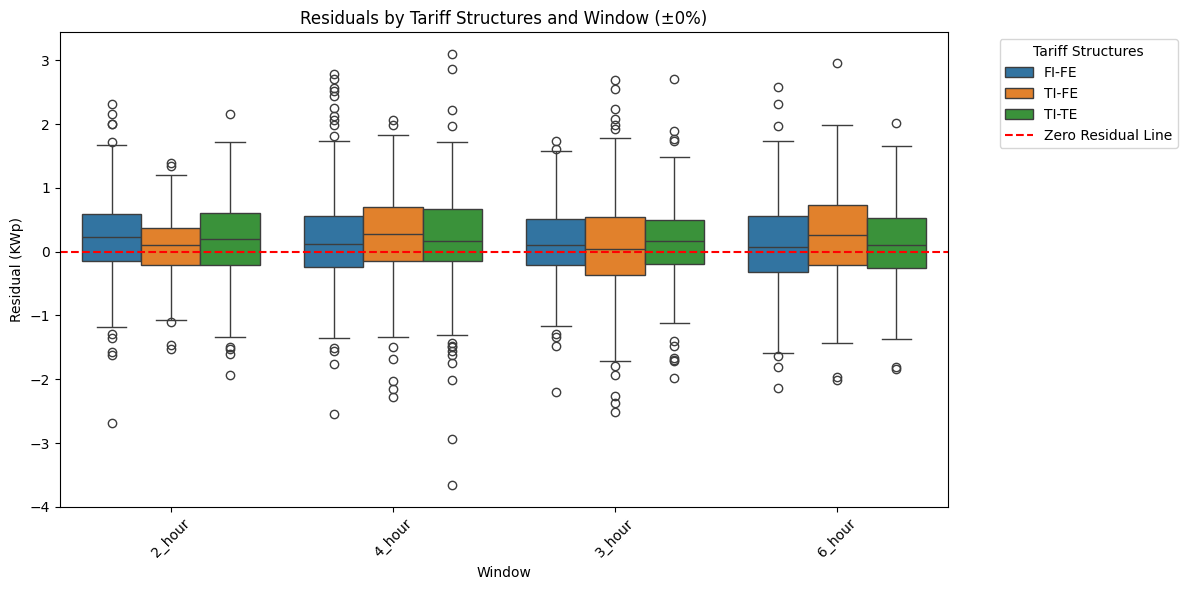

Residual boxplot saved to: residual_analysis/residuals_boxplot_by_tariff_structures_and_window_cleaned.png


In [165]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the predictions file
predictions_file = "corrected_predictions.csv"  # Replace with your file path
df = pd.read_csv(predictions_file)

# Step 2: Debug the original Window column values
print("Original Window column unique values (before cleaning):")
print(df['Window'].unique())

# Step 3: Clean Tariff Structures (formerly Scenario)
scenario_mapping = {
    'Flat-Flat': 'FI-FE',                      # Fixed Import - Fixed Export
    'Time-varying-Time-varying': 'TI-TE',      # Time-varying Import - Time-varying Export
    'Time-varying-Flat': 'TI-FE'               # Time-varying Import - Fixed Export
}

# Replace Scenario with Tariff Structures
df['Tariff Structures'] = df['Scenario'].replace(scenario_mapping)

# Drop the old Scenario column
df.drop(columns=['Scenario'], inplace=True)

# Step 4: Clean the Window column
# Remove unwanted patterns, including "te_"
df['Window'] = (
    df['Window']
    .str.replace(r'te_', '', regex=True)       # Remove "te_"
    .str.replace(r'^[ABC]_', '', regex=True)  # Remove prefixes A_, B_, C_
    .str.replace(r'0_', '', regex=True)       # Remove "0_"
    .str.strip()                              # Remove leading/trailing whitespace
)

# Debug the cleaned Window column
print("Cleaned Window column unique values (after cleaning):")
print(df['Window'].unique())

# Step 5: Verify the updated DataFrame
print("Columns in DataFrame:", df.columns)
print("First few rows of DataFrame:")
print(df.head())

# Step 6: Create output directory for plots
output_dir = "residual_analysis"
os.makedirs(output_dir, exist_ok=True)

# Step 7: Generate boxplots for each Tariff Structure and Window
plt.figure(figsize=(12, 6))
sns.boxplot(x='Window', y='Residual', hue='Tariff Structures', data=df)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title("Residuals by Tariff Structures and Window (±0%)")
plt.xlabel("Window")
plt.ylabel("Residual (KWp)")
plt.xticks(rotation=45)
plt.legend(title='Tariff Structures', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plot_file = os.path.join(output_dir, "residuals_boxplot_by_tariff_structures_and_window_cleaned.png")
plt.savefig(plot_file)
plt.show()

print(f"Residual boxplot saved to: {plot_file}")


In [142]:
def save_combined_features_with_datetime(scenario, window, start_date, end_date, output_dir="reconnected_combined_data"):
    """
    Save combined features (meter, solar, tariffs) with datetime for post-analysis.

    Args:
        scenario (str): Scenario name.
        window (int): Window size in hours.
        start_date (str): Start date for datetime index.
        end_date (str): End date for datetime index.
        output_dir (str): Directory to save combined data.
    """
    try: 
        # Generate datetime index
        datetime_index = pd.date_range(
            start=start_date,
            end=end_date,
            freq=f"{window}h",
            inclusive="left"
        )
        n_timesteps = len(datetime_index)
        
        # File paths
        combined_path = f"corrected_sequential_results/{scenario}_{window}_hour_combined_features.csv"
        output_path = os.path.join(output_dir, f"{scenario}_{window}h_combined.csv")
        
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Load combined features
        combined_df = pd.read_csv(combined_path, header=None)
        
        # Validate feature counts
        expected_features = 4 * n_timesteps  # Meter, solar, import_tariff, export_tariff
        if combined_df.shape[1] != expected_features + 1:  # +1 for target
            raise ValueError(f"Feature count mismatch: Expected {expected_features + 1}, got {combined_df.shape[1]}")
        
        # Split features
        meter = combined_df.iloc[:, :n_timesteps]
        solar = combined_df.iloc[:, n_timesteps:2 * n_timesteps]
        import_tariff = combined_df.iloc[:, 2 * n_timesteps:3 * n_timesteps]
        export_tariff = combined_df.iloc[:, 3 * n_timesteps:4 * n_timesteps]
        target = combined_df.iloc[:, -1]
        
        # Combine into a single DataFrame
        combined_features = pd.concat([meter, solar, import_tariff, export_tariff], axis=1)
        combined_features.columns = [
            f"{feature}_{time}" for feature in ['meter', 'solar', 'import_tariff', 'export_tariff']
            for time in datetime_index
        ]
        combined_features['target'] = target.values
        
        # Save to CSV
        combined_features.to_csv(output_path, index=False)
        print(f"Saved combined data to: {output_path}")
    
    except FileNotFoundError:
        print(f"File not found: {combined_path}")
    except ValueError as e:
        print(f"Error processing {scenario} {window}h: {e}")
    except Exception as e:
        print(f"Unexpected error for {scenario} {window}h: {e}")

# Example usage
scenarios = ["A_0_te", "B_0_te", "C_0_te"]
windows = [2, 3, 4, 6]
start_date = "2019-04-01"
end_date = "2020-03-31"

for scenario in scenarios:
    for window in windows:
        print(f"\nProcessing Scenario: {scenario}, Window: {window}h")
        save_combined_features_with_datetime(scenario, window, start_date, end_date)


Processing Scenario: A_0_te, Window: 2h
Saved combined data to: reconnected_combined_data/A_0_te_2h_combined.csv

Processing Scenario: A_0_te, Window: 3h
Saved combined data to: reconnected_combined_data/A_0_te_3h_combined.csv

Processing Scenario: A_0_te, Window: 4h
Saved combined data to: reconnected_combined_data/A_0_te_4h_combined.csv

Processing Scenario: A_0_te, Window: 6h
Saved combined data to: reconnected_combined_data/A_0_te_6h_combined.csv

Processing Scenario: B_0_te, Window: 2h
Saved combined data to: reconnected_combined_data/B_0_te_2h_combined.csv

Processing Scenario: B_0_te, Window: 3h
Saved combined data to: reconnected_combined_data/B_0_te_3h_combined.csv

Processing Scenario: B_0_te, Window: 4h
Saved combined data to: reconnected_combined_data/B_0_te_4h_combined.csv

Processing Scenario: B_0_te, Window: 6h
Saved combined data to: reconnected_combined_data/B_0_te_6h_combined.csv

Processing Scenario: C_0_te, Window: 2h
Saved combined data to: reconnected_combined_da

In [ ]:
import os

def extract_and_save_seasonal_data(meter_ts, solar_ts, tariffs, datetime_index, scenario, window, output_dir="seasonal_data"):
    """
    Extract seasonal data and save it as CSV files for meter, solar, and tariffs.

    Args:
        meter_ts (pd.DataFrame): Meter data with houses as rows and datetime as columns.
        solar_ts (pd.DataFrame): Solar data with houses as rows and datetime as columns.
        tariffs (dict): Dictionary with 'import' and 'export' tariff data.
        datetime_index (pd.DatetimeIndex): Datetime index for the columns.
        scenario (str): Scenario name.
        window (int): Window size in hours.
        output_dir (str): Directory to save seasonal data.
    """
    # Define seasons
    season_masks = {
        'autumn': (datetime_index >= "2019-03-01") & (datetime_index < "2019-06-01"),
        'winter': (datetime_index >= "2019-06-01") & (datetime_index < "2019-09-01"),
        'spring': (datetime_index >= "2019-09-01") & (datetime_index < "2019-12-01"),
        'summer': (datetime_index >= "2019-12-01") & (datetime_index < "2020-03-01"),
    }

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for season, mask in season_masks.items():
        print(f"\nProcessing Season: {season}, Scenario: {scenario}, Window: {window}h")
        
        # Apply seasonal mask to columns
        seasonal_data = {
            'meter': meter_ts.loc[:, mask],
            'solar': solar_ts.loc[:, mask],
            'import_tariff': tariffs['import'].loc[:, mask],
            'export_tariff': tariffs['export'].loc[:, mask],
        }

        # Save each category as CSV
        for category, df in seasonal_data.items():
            filepath = os.path.join(output_dir, f"{scenario}_{window}h_{season}_{category}.csv")
            df.to_csv(filepath, index=False)
            print(f"  Saved {category} data to: {filepath}")

        # Save the season's data summary if needed
        print(f"  Meter Shape: {seasonal_data['meter'].shape}")
        print(f"  Solar Shape: {seasonal_data['solar'].shape}")
        print(f"  Import Tariff Shape: {seasonal_data['import_tariff'].shape}")
        print(f"  Export Tariff Shape: {seasonal_data['export_tariff'].shape}")

# Example Usage
scenarios = ["A_0_te", "B_0_te", "C_0_te"]
windows = [2, 3, 4, 6]
start_date = "2019-04-01"
end_date = "2020-03-31"

for scenario in scenarios:
    for window in windows:
        print(f"\nProcessing Scenario: {scenario}, Window: {window}h")

        # Load reconnected combined data
        combined_path = f"reconnected_combined_data/{scenario}_{window}h_combined.csv"
        combined_data = pd.read_csv(combined_path)
        
        # Extract meter, solar, and tariffs from combined data
        meter_ts = combined_data.filter(like='meter')
        solar_ts = combined_data.filter(like='solar')
        import_tariff = combined_data.filter(like='import_tariff')
        export_tariff = combined_data.filter(like='export_tariff')

        # Prepare tariffs
        tariffs = {'import': import_tariff, 'export': export_tariff}

        # Create datetime index
        datetime_index = pd.date_range(start=start_date, end=end_date, freq=f"{window}h", inclusive="left")

        # Extract and save seasonal data
        extract_and_save_seasonal_data(meter_ts, solar_ts, tariffs, datetime_index, scenario, window)


In [2]:
def seasonal_duck_curve_tariff_analysis(scenario, window_size, combined_results_dir="combined_results", output_dir="seasonal_analysis_results"):
    """
    Analyze the duck curve with seasonal patterns and tariffs, and save results to a CSV.
    """
    # Construct the file path
    combined_file = os.path.join(combined_results_dir, f"{scenario}_{window_size}h_combined_results.csv")
    if not os.path.exists(combined_file):
        print(f"File not found: {combined_file}")
        return
    
    # Load the combined data
    data = pd.read_csv(combined_file)
    
    # Identify meter, solar, and tariff columns
    meter_columns = [col for col in data.columns if "meter" in col]
    solar_columns = [col for col in data.columns if "solar" in col]
    import_tariff_columns = [col for col in data.columns if "import_tariff" in col]
    export_tariff_columns = [col for col in data.columns if "export_tariff" in col]
    datetime_index = pd.to_datetime([col.split('_')[-1] for col in meter_columns])
    
    # Define seasons
    seasons = {
        'autumn': (datetime_index >= "2019-03-01") & (datetime_index < "2019-06-01"),
        'winter': (datetime_index >= "2019-06-01") & (datetime_index < "2019-09-01"),
        'spring': (datetime_index >= "2019-09-01") & (datetime_index < "2019-12-01"),
        'summer': (datetime_index >= "2019-12-01") & (datetime_index < "2020-03-01")
    }
    
    # Define morning and evening peak hours
    morning_hours = range(10, 15)
    evening_hours = range(16, 22)
    
    results = []  # Store results for saving
    
    # Analyze each season
    for season, mask in seasons.items():
        print(f"\nAnalyzing {season.capitalize()} for {scenario}, {window_size}h windows:")
        
        # Filter columns for the season
        season_columns = [meter_columns[i] for i, in_season in enumerate(mask) if in_season]
        solar_season_columns = [solar_columns[i] for i, in_season in enumerate(mask) if in_season]
        import_season_columns = [import_tariff_columns[i] for i, in_season in enumerate(mask) if in_season]
        export_season_columns = [export_tariff_columns[i] for i, in_season in enumerate(mask) if in_season]
        
        # Filter morning and evening columns
        morning_columns = [col for col in season_columns if int(pd.to_datetime(col.split('_')[-1]).hour) in morning_hours]
        evening_columns = [col for col in season_columns if int(pd.to_datetime(col.split('_')[-1]).hour) in evening_hours]
        
        solar_morning_columns = [col for col in solar_season_columns if int(pd.to_datetime(col.split('_')[-1]).hour) in morning_hours]
        solar_evening_columns = [col for col in solar_season_columns if int(pd.to_datetime(col.split('_')[-1]).hour) in evening_hours]
        
        # Compute averages
        morning_avg_consumption = data[morning_columns].mean().mean()
        evening_avg_consumption = data[evening_columns].mean().mean()
        
        morning_avg_solar = data[solar_morning_columns].mean().mean()
        evening_avg_solar = data[solar_evening_columns].mean().mean()
        
        # Compute average tariffs
        morning_avg_import_tariff = data[import_season_columns].mean().mean()
        evening_avg_export_tariff = data[export_season_columns].mean().mean()
        
        # Relate to PV sizes
        avg_predicted_pv = data['Predicted'].mean()
        avg_actual_pv = data['Actual'].mean()
        avg_residual = data['Residual'].mean()
        
        # Append results to list
        results.append({
            "Scenario": scenario,
            "Window": f"{window_size}h",
            "Season": season.capitalize(),
            "Morning Consumption (kWh)": morning_avg_consumption,
            "Evening Consumption (kWh)": evening_avg_consumption,
            "Morning Solar Generation (kWh)": morning_avg_solar,
            "Evening Solar Generation (kWh)": evening_avg_solar,
            "Morning Import Tariff (cents/kWh)": morning_avg_import_tariff,
            "Evening Export Tariff (cents/kWh)": evening_avg_export_tariff,
            "Avg Predicted PV Size (kWp)": avg_predicted_pv,
            "Avg Actual PV Size (kWp)": avg_actual_pv,
            "Avg Residual (kWp)": avg_residual
        })
    
    # Save results to a CSV
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{scenario}_{window_size}h_seasonal_analysis_v2.csv")
    pd.DataFrame(results).to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
